This script is used to produce the plots from our Deepmind Contrl Suite experiments in our
paper. If you'd like to use this script on your own data, check the README,
and follow the same approach used in the `1_grid_search` section.

# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BENCHMARK_NAME = 'dmc'

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import deepcopy
from dataclasses import dataclass
from typing import List
from collections import defaultdict
from tqdm import tqdm

from qscaled.utils.configs import BaseConfig
from qscaled.utils.zip_handler import fetch_zip_data
from qscaled.core.preprocessing import bootstrap_crossings

from scripts.zip_handler import ModelSizeZipHandler
from scripts.collector import BROModelScalingCollector
from scripts.core.preprocess import (
    bootstrap_crossings_per_env,
    fill_isotonic_regression,
    truncate,
    filter_out_resets,
    load_data,
)
from scripts.generate_runs.constants import DEFAULT_MAX_STEPS

from scripts.core.bootstrapping import (
    insert_predictions_shared_slope,
    predict_log_linear,
    insert_predictions,
    predict_log_linear_shared_slope,
    insert_predictions_sum_powerlaw,
    predict_sum_of_powerlaw,
    insert_predictions_sum_of_powerlaw_shared_exponent,
    predict_sum_of_powerlaw_shared_exponent,
)

from scripts.experiments.utd_x_width_x_bs.plot_utils import (
    plot_learning_curves_with_thresholds,
    plot_optimal_hparams_scatter,
    compute_optimal_budget,
    plot_multiple_budget_optimal,
    compute_budget_data_compute_equation,
    insert_budget_fitted_hparams,
    plot_budget_data_opt_pretty,
    plot_budget_compute_opt_pretty,
    plot_budget_sigma_opt_pretty,
    plot_budget_n_opt_pretty,
)
from scripts.experiments.bro_ablations.plot_utils import (
    learning_curves_per_utd,
    learning_curves_per_model_size,
    compute_data_efficiency_per_env,
    compute_normalized_times,
)

from scripts.experiments.bro_ablations.plot_utils import (
    plot_optimal_hparam_fit_per_env_n_multiple_thresh,
    plot_optimal_hparam_fit_per_env_utd_multiple_thresh,
)

from scripts.utils import pretty_print_dict

from scripts.experiments.bro_ablations.config import config

import qscaled
from qscaled.core.fitted import data_efficiency as qscaled_data_efficiency

qscaled.constants.suppress_overwrite_prompt = True

**Note:** Due to bootstrapping, outputs are randomized. We have set a random seed,
so if you restart the kernel and run all cells, your final `csv` output should
be deterministic.

In [4]:
global_use_cached = True

In [ ]:
compute_optimal_collector = BROModelScalingCollector(
    'anonymous',
    'BRO_model_scaling',
    # wandb_tags=['dmc_compute_optimal_shared_exp_250509', 'dmc_compute_optimal_shared_exp_250511'],
    wandb_tags=['dmc_shared_exp_compute_optimal_250520'],
    use_cached=global_use_cached and True,
)
compute_optimal_collector.remove_short()
compute_optimal_collector = compute_optimal_collector.flatten()

In [ ]:
@dataclass(kw_only=True)
class ModelSizeSweepConfig(BaseConfig):
    utds_to_predict: List[float]  # UTDs to predict hyperparams for
    model_sizes_to_predict: List[int]


config_input_dict = dict(
    max_returns={},
    returns_key='return',
    utds_to_predict=[0.25, 0.5, 1, 2, 4, 8, 16, 32],
    model_sizes_to_predict=[128, 256, 512, 1024, 2048, 4096],
    thresholds=[],  # placeholder
)

anonymous_data_config = ModelSizeSweepConfig(
    name=f'anonymous_bro_{BENCHMARK_NAME}',  # Zip filename
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

compute_optimal_config = ModelSizeSweepConfig(
    name=f'{BENCHMARK_NAME}_compute_optimal_shared_exp_250520',  # Zip filename
    wandb_collector=compute_optimal_collector,
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

truncate_steps = DEFAULT_MAX_STEPS


def linear_threshold_fn(env, max_thresh):
    return np.linspace(2 / n_thresholds, 1, n_thresholds) * max_thresh


def linear_threshold_with_base(env, max_thresh):
    base = {
        'acrobot-swingup': 200,
        'cheetah-run': 450,
        'finger-turn': 400,
        'fish-swim': 200,
        'hopper-hop': 150,
        'quadruped-run': 200,
        'walker-run': 350,
        'pendulum-swingup': 0,
    }
    return np.linspace(base[env], max_thresh, n_thresholds)


n_thresholds = 20
threshold_fn_to_use = linear_threshold_with_base
threshold_description = '_linear20_with_base'

anonymous_data_config.name += threshold_description
compute_optimal_config.name += threshold_description

In [7]:
compute_optimal_df = fetch_zip_data(compute_optimal_config, use_cached=global_use_cached and True)

In [8]:
global_use_cached = True

In [ ]:
def preprocess(df, config, use_cached, max_threshold_per_env=None):
    truncate_steps = DEFAULT_MAX_STEPS

    df = deepcopy(df)
    df = truncate(df, truncate_steps)
    df = filter_out_resets(df, reset_freq=2.5e6)

    fill_isotonic_regression(
        df,
        training_step_key='training_step_resetfilter',
        mean_return_key='mean_return_resetfilter',
    )

    if max_threshold_per_env is None:
        max_threshold_per_env = (
            # df.query(threshold_filter).groupby('env_name')['final_return_isotonic'].min().to_dict()
            df.query(threshold_filter)
            .groupby('env_name')['final_return_isotonic']
            .quantile(0.2)
            .to_dict()
        )
        max_threshold_per_env = {k: (0.95 * v // 10) * 10 for k, v in max_threshold_per_env.items()}

    df, _, thresholds_per_env = bootstrap_crossings_per_env(
        df,
        manual_thresholds=max_threshold_per_env,
        max_threshold_to_thresholds_fn=threshold_fn_to_use,
        training_step_key='training_step_resetfilter',
        return_key='return_resetfilter',
        filename=config.name,
        use_cached=use_cached,
    )

    df['mean_return_over_training'] = df['return'].apply(lambda x: np.mean(x))
    df['std_return_over_training'] = df['return'].apply(
        lambda x: x.mean(axis=0).std() / np.sqrt(x.shape[1])
    )
    return df, max_threshold_per_env, thresholds_per_env


df = load_data().query(f'benchmark == "{BENCHMARK_NAME}"')
threshold_filter = config[BENCHMARK_NAME]['threshold_filter']
good_envs = config[BENCHMARK_NAME].get('good_envs')

df, max_threshold_per_env, thresholds_per_env = preprocess(
    df, anonymous_data_config, use_cached=global_use_cached and True
)

envs = sorted(list(df['env_name'].unique()))
compute_optimal_df = compute_optimal_df.query(
    f'env_name in {envs}'
)  # contains both dmc and dog-humanoid

compute_optimal_df, _, _ = preprocess(
    compute_optimal_df,
    compute_optimal_config,
    use_cached=global_use_cached and True,
    max_threshold_per_env=max_threshold_per_env,
)

Average standard deviation across all conditions: 29539.86
Average standard deviation across all conditions: 25839.87


In [11]:
max_threshold_per_env

{'acrobot-swingup': 400.0,
 'cheetah-run': 750.0,
 'finger-turn': 900.0,
 'fish-swim': 710.0,
 'hopper-hop': 320.0,
 'pendulum-swingup': 790.0,
 'quadruped-run': 790.0,
 'walker-run': 730.0}

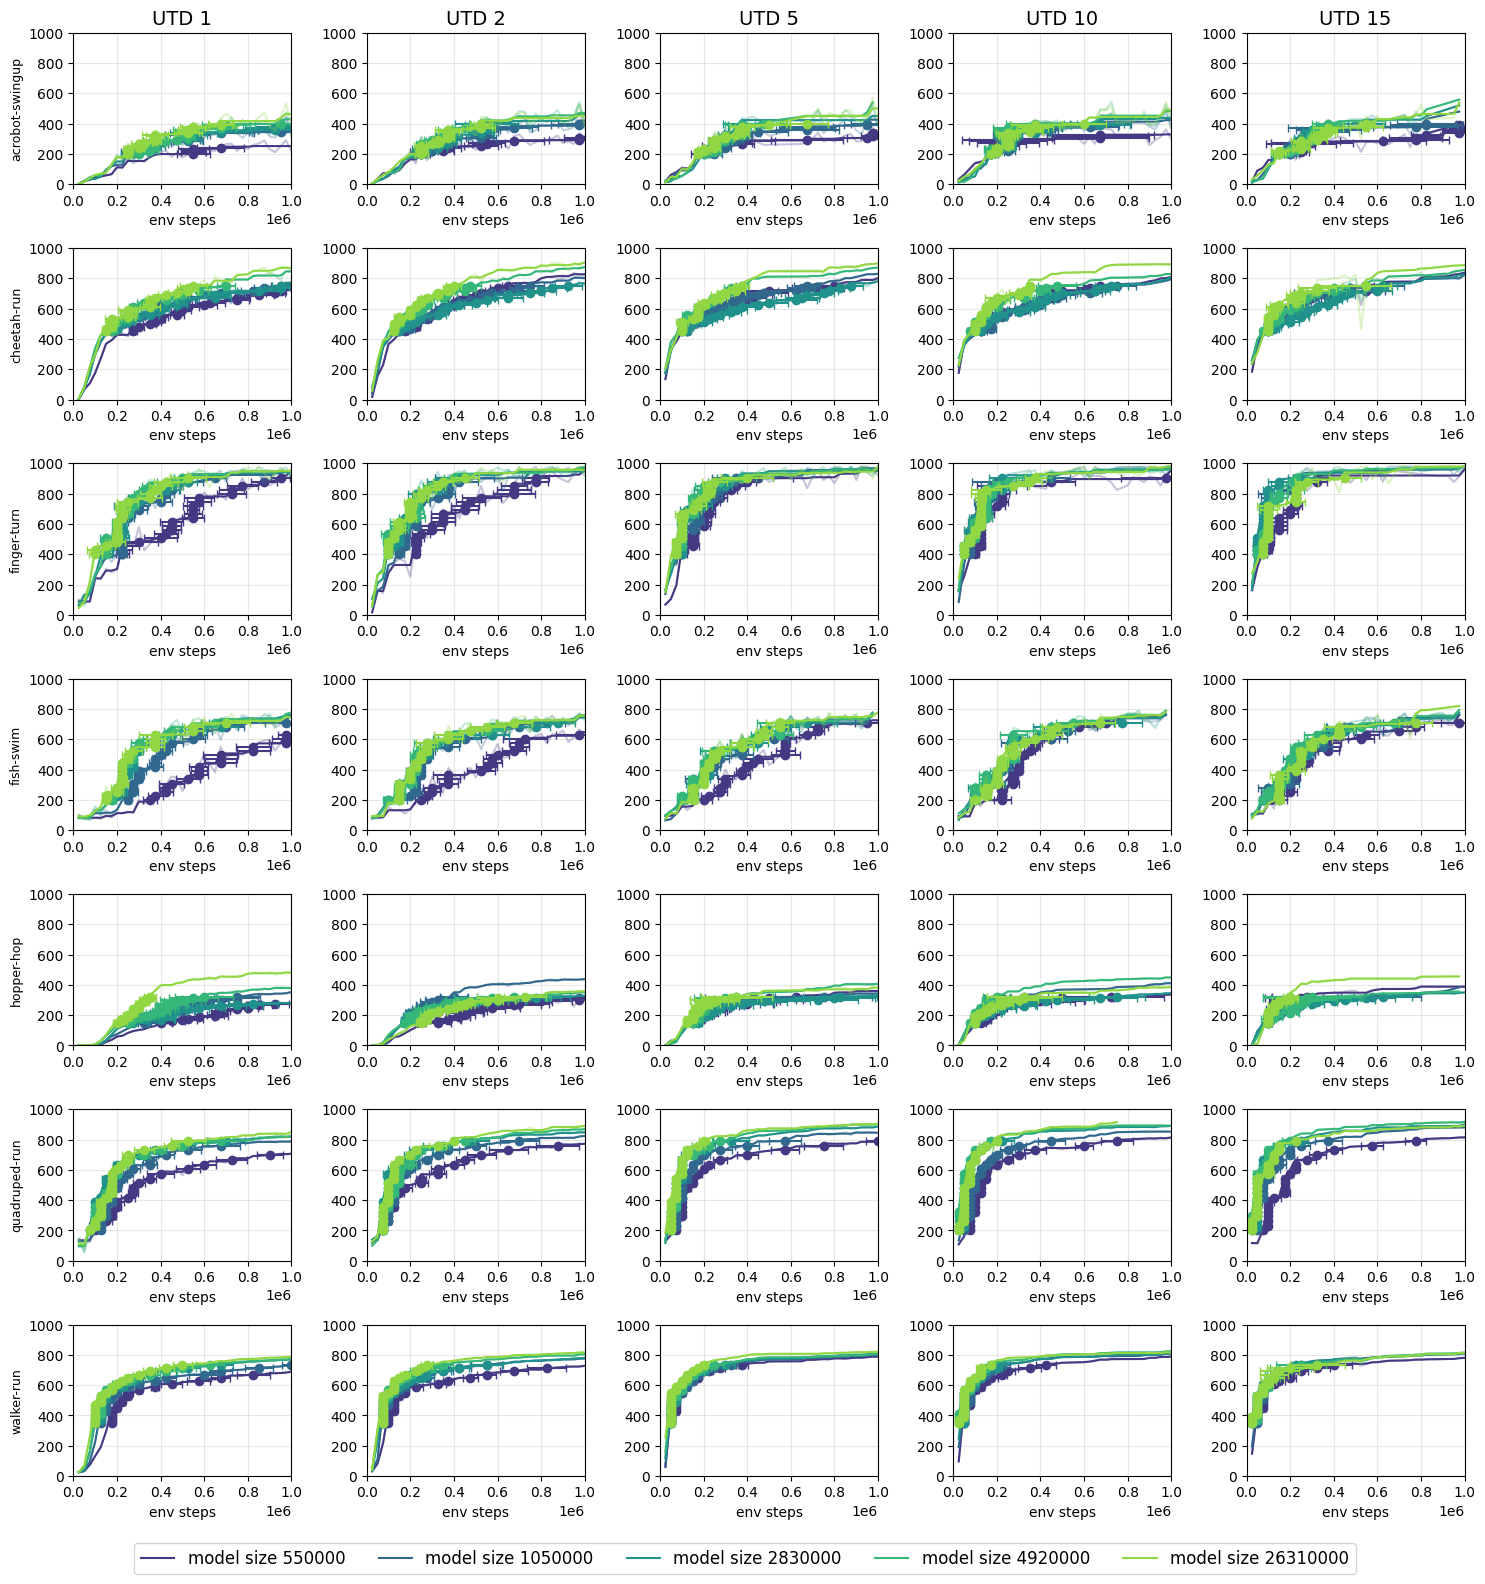

In [12]:
learning_curves_per_utd(df, ylabel_fontsize=9)

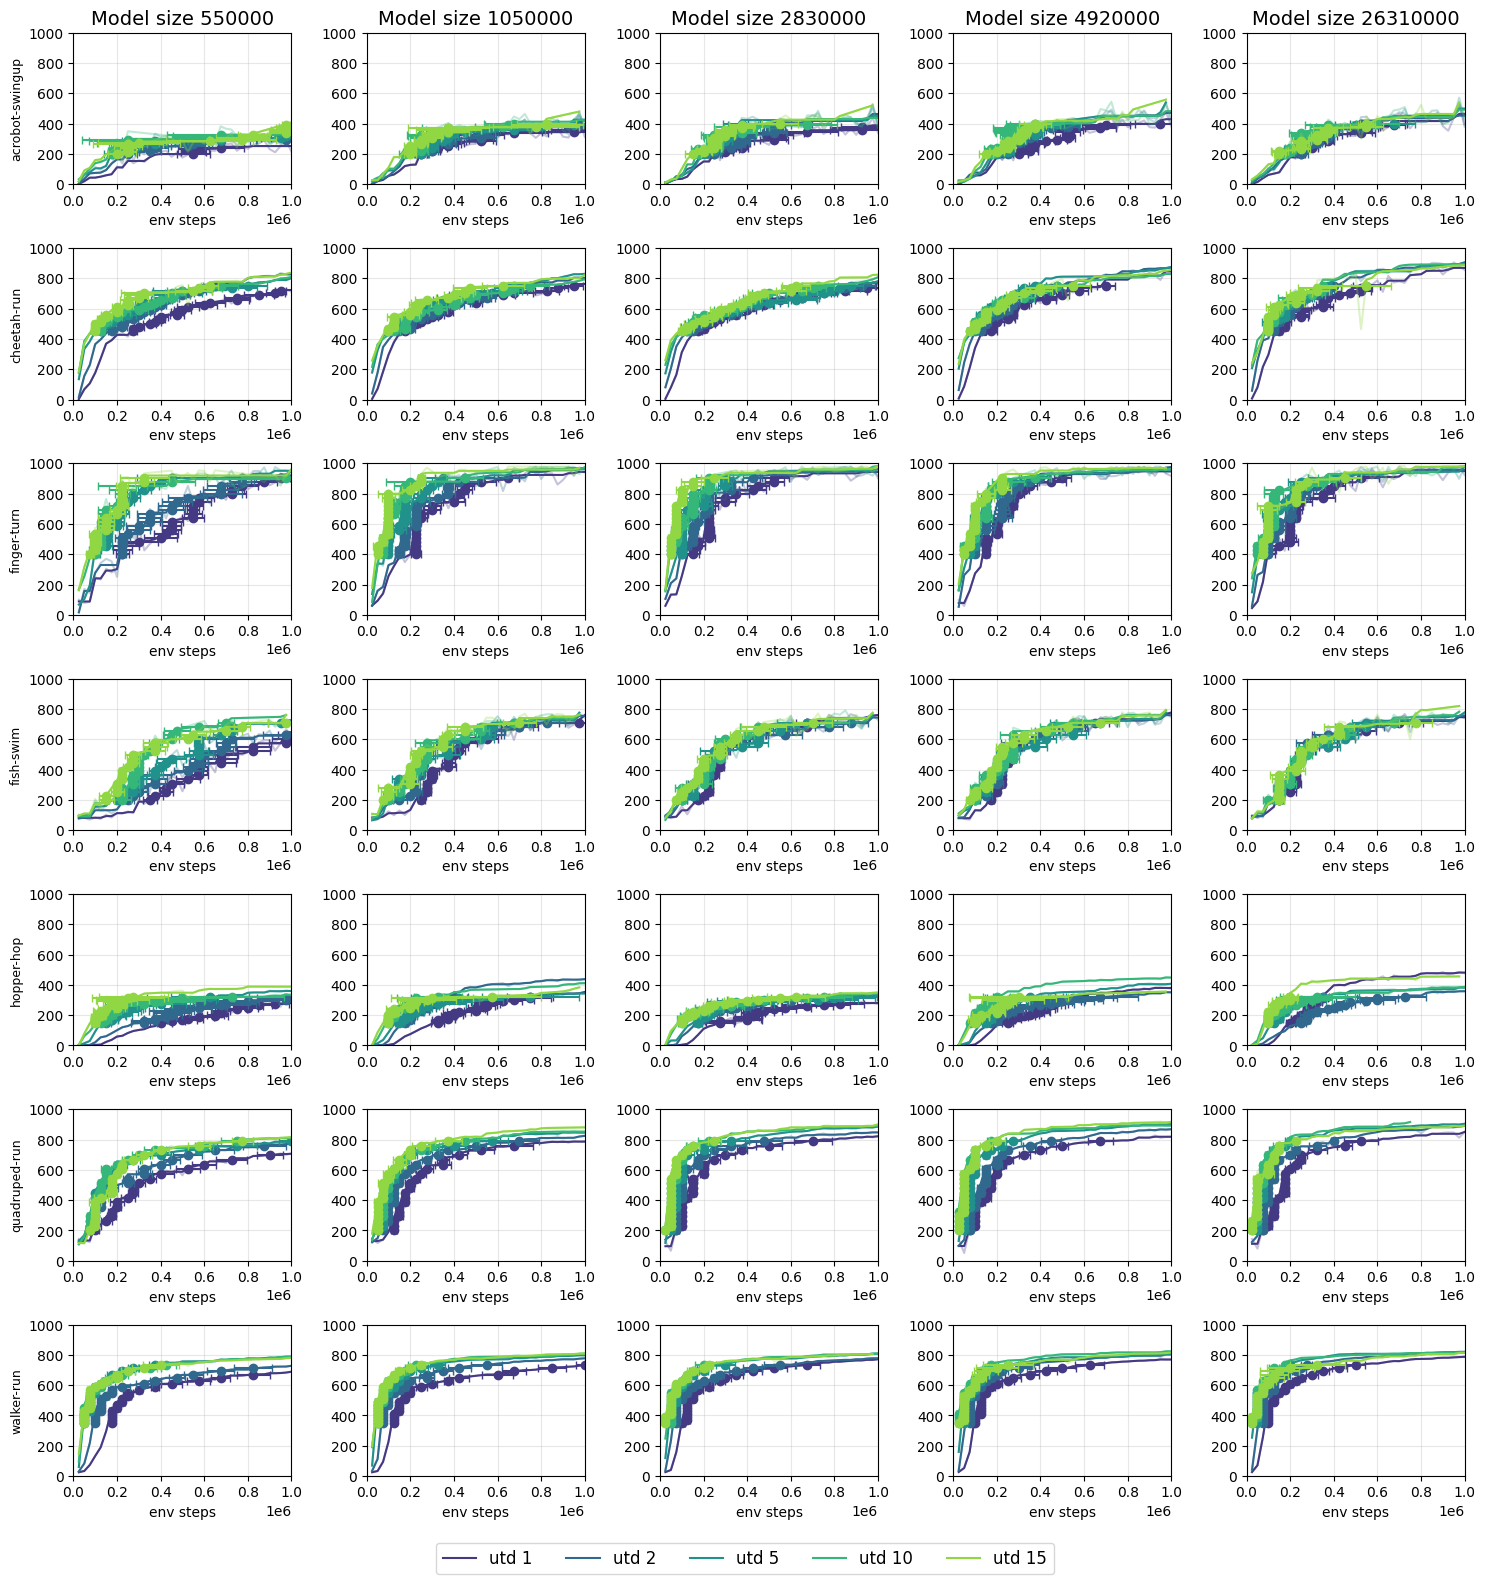

In [13]:
learning_curves_per_model_size(df, ylabel_fontsize=9)

# Data efficiency

In [14]:
env_data_efficiency_dict = compute_data_efficiency_per_env(df)

env=acrobot-swingup, utd=1, model_size=550000 has at least one nanmax return 251.63321314900125
env=acrobot-swingup, utd=1, model_size=1050000 has at least one nanmax return 378.37028159665306
env=acrobot-swingup, utd=1, model_size=2830000 has at least one nanmax return 388.5886552314407
env=acrobot-swingup, utd=2, model_size=550000 has at least one nanmax return 313.12774165402726
env=acrobot-swingup, utd=5, model_size=550000 has at least one nanmax return 337.90854266050053
env=acrobot-swingup, utd=10, model_size=550000 has at least one nanmax return 328.6637204883796
env=acrobot-swingup, utd=15, model_size=550000 has at least one nanmax return 396.2364236427253
env=cheetah-run, utd=1, model_size=550000 has at least one nanmax return 722.690098261833
env=fish-swim, utd=1, model_size=550000 has at least one nanmax return 635.9278125278439
env=fish-swim, utd=2, model_size=550000 has at least one nanmax return 647.0981731418451
env=hopper-hop, utd=1, model_size=550000 has at least one n

In [ ]:
def query(df, good_envs):
    if good_envs is None:
        return df
    return df.query(f'env_name in {good_envs}')


filtered_df = df.query(threshold_filter)

# Data efficiency fit per task

In [ ]:
df['critic_params'] = df['model_size']
df['last_crossing'] = df['crossings'].apply(lambda x: x[-1])
df['last_crossing_std'] = df['crossings_std'].apply(lambda x: x[-1])
fit_df = df.dropna(subset=['last_crossing'])
xcols = ['utd', 'critic_params']

In [21]:
(
    fit_df,
    (
        time_to_thresh_model,
        time_to_thresh_shared_slope,
        time_to_thresh_env_intercepts,
        time_to_thresh_r2,
    ),
) = insert_predictions_shared_slope(fit_df, xcols, 'last_crossing')

predict_data_efficiency_shared_slope_ = lambda df: predict_log_linear_shared_slope(
    df, xcols, time_to_thresh_shared_slope, time_to_thresh_env_intercepts
)

acrobot-swingup: log last_crossing ~ 1.5728e+01 + -0.1988 * log utd + -0.1362 * log critic_params
cheetah-run: log last_crossing ~ 1.5671e+01 + -0.1988 * log utd + -0.1362 * log critic_params
finger-turn: log last_crossing ~ 1.5274e+01 + -0.1988 * log utd + -0.1362 * log critic_params
fish-swim: log last_crossing ~ 1.5837e+01 + -0.1988 * log utd + -0.1362 * log critic_params
hopper-hop: log last_crossing ~ 1.5447e+01 + -0.1988 * log utd + -0.1362 * log critic_params
quadruped-run: log last_crossing ~ 1.5265e+01 + -0.1988 * log utd + -0.1362 * log critic_params
walker-run: log last_crossing ~ 1.5080e+01 + -0.1988 * log utd + -0.1362 * log critic_params


In [ ]:
fit_df, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
    fit_df,
    xcols,
    'last_crossing',
    name=anonymous_data_config.name,
    use_cached=global_use_cached and True,
    log_loss=True,
)

predict_data_efficiency_sum_powerlaw_ = lambda df: predict_sum_of_powerlaw(
    df, xcols, time_to_thresh_sum_powerlaw_params
)

data_efficiency_sum_powerlaw_asymptotes_utd = {
    (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
    for k, params in time_to_thresh_sum_powerlaw_params.items()
    for utd in df['utd'].unique()
}

data_efficiency_sum_powerlaw_asymptotes_n = {
    (k, n): params[4] * (1 + (params[2] / n) ** params[3])
    for k, params in time_to_thresh_sum_powerlaw_params.items()
    for n in df['critic_params'].unique()
}

pd.DataFrame(
    [
        {
            'env_name': k,
            'a': params[0],
            'alpha': params[1],
            'b': params[2],
            'beta': params[3],
            'c': params[4],
            'alpha_unscaled': params[5],
            'beta_unscaled': params[6],
            'a_unscaled': params[7],
            'b_unscaled': params[8],
            'c_unscaled': params[9],
        }
        for k, params in time_to_thresh_sum_powerlaw_params.items()
    ]
)

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base/utd_critic_params_last_crossing_sum_powerlaw.npy


env_name             a     alpha             b       beta  \
0  acrobot-swingup      0.851746  3.194987  1.009873e+06  10.553707   
1      cheetah-run      3.255112  2.562900  4.964788e+16   0.164865   
2      finger-turn      1.395867  0.784066  5.524984e+05   2.945984   
3        fish-swim      0.121452  0.262902  4.011108e+05   1.937318   
4       hopper-hop  21141.540856  0.334169  1.233984e+17   0.090589   
5    quadruped-run      9.981129  0.716218  1.857088e+06   1.517853   
6       walker-run      1.533621  1.437714  4.398931e+05   2.356116   

               c  alpha_unscaled  beta_unscaled  a_unscaled   b_unscaled  \
0  500773.223961        6.241232      24.522330    0.460569     0.491685   
1   11298.551413        5.006485       0.459977    0.914873  4223.387559   
2  240185.688838        1.531629       8.219349    0.593086     0.500813   
3  463977.008502        0.513565       5.405153    0.169927     0.446510   
4   18035.005004        0.652780       0.252746   81.860966  5853.068567   
5   94982.153790        1.399094       4.234838    1.623552     0.773365   
6  234164.906401        2.808495       6.573606    0.622361     0.461528   

   c_unscaled  
0    0.816609  
1    0.018078  
2    0.537328  
3    0.656706  
4    0.033342  
5    0.217667  
6    0.598421

In [ ]:
fit_df, time_to_thresh_sum_powerlaw_shared_exponent_params = (
    insert_predictions_sum_of_powerlaw_shared_exponent(
        fit_df,
        xcols,
        'last_crossing',
        name=anonymous_data_config.name,
        use_cached=global_use_cached,
        log_loss=True,
    )
)

predict_data_efficiency_sum_powerlaw_shared_exponent_ = (
    lambda df: predict_sum_of_powerlaw_shared_exponent(
        df, xcols, time_to_thresh_sum_powerlaw_shared_exponent_params
    )
)

data_efficiency_sum_powerlaw_shared_exponent_asymptotes_utd = {
    (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
    for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
    for utd in df['utd'].unique()
}

data_efficiency_sum_powerlaw_shared_exponent_asymptotes_n = {
    (k, n): params[4] * (1 + (params[2] / n) ** params[3])
    for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
    for n in df['critic_params'].unique()
}

data_efficiency_sum_powerlaw_shared_exp_params_df = pd.DataFrame(
    [
        {
            'env_name': k,
            'a': params[0],
            'alpha': params[1],
            'b': params[2],
            'beta': params[3],
            'c': params[4],
            'alpha_unscaled': params[5],
            'beta_unscaled': params[6],
            'a_unscaled': params[7],
            'b_unscaled': params[8],
            'c_unscaled': params[9],
        }
        for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
    ]
)

data_efficiency_sum_powerlaw_shared_exp_params_df

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base/utd_critic_params_last_crossing_sum_of_powerlaw_shared_exp.npy


env_name         a    alpha             b      beta              c  \
0  acrobot-swingup  0.646272  0.98266  8.418625e+05  1.389373  428876.073552   
1      cheetah-run  0.429987  0.98266  3.395173e+05  1.389373  480602.532341   
2      finger-turn  1.077082  0.98266  4.671671e+05  1.389373  266036.608566   
3        fish-swim  0.136499  0.98266  2.702305e+05  1.389373  628444.479890   
4       hopper-hop  0.824492  0.98266  3.118779e+05  1.389373  351962.162096   
5    quadruped-run  3.538031  0.98266  1.639500e+06  1.389373  139413.850638   
6       walker-run  2.847532  0.98266  6.067014e+05  1.389373  161065.213040   

   alpha_unscaled  beta_unscaled  a_unscaled  b_unscaled  c_unscaled  
0        1.919573       3.876375    0.399870    0.582417    0.592441  
1        1.919573       3.876375    0.324586    0.420611    0.663895  
2        1.919573       3.876375    0.519372    0.471587    0.367498  
3        1.919573       3.876375    0.180397    0.387571    0.868122  
4        1.919573       3.876375    0.452965    0.408003    0.486194  
5        1.919573       3.876375    0.954750    0.739582    0.192584  
6        1.919573       3.876375    0.854318    0.517897    0.222492

In [25]:
def print_data_efficiency_params(params_df):
    for _, row in params_df.iterrows():
        env_name, a, alpha, b, beta, c = row[['env_name', 'a', 'alpha', 'b', 'beta', 'c']].values
        print(
            r'\texttt{[[env]]}'.replace(r'[[env]]', env_name.replace('-v0', '')),
            r'&\qquad',
            r'\mathrm{[[c]]} \left(1 + \parens{\tfrac{\mathrm{[[a]]}}{\sigma}}^{[[\alpha]]} + \parens{\tfrac{\mathrm{[[b]]}}{N}}^{[[\beta]]} \right)'.replace(
                r'[[a]]', f'{a:.2e}'
            )
            .replace(r'[[b]]', f'{b:.2e}')
            .replace(r'[[c]]', f'{c:.2e}')
            .replace(r'[[\alpha]]', f'{alpha:.2f}')
            .replace(r'[[\beta]]', f'{beta:.2f}')
            .replace('e+0', r'e')
            .replace('e-0', r'e\text{-}'),
            r'\\',
        )


print_data_efficiency_params(data_efficiency_sum_powerlaw_shared_exp_params_df)

\texttt{acrobot-swingup} &\qquad \mathrm{4.29e5} \left(1 + \parens{\tfrac{\mathrm{6.46e\text{-}1}}{\sigma}}^{0.98} + \parens{\tfrac{\mathrm{8.42e5}}{N}}^{1.39} \right) \\
\texttt{cheetah-run} &\qquad \mathrm{4.81e5} \left(1 + \parens{\tfrac{\mathrm{4.30e\text{-}1}}{\sigma}}^{0.98} + \parens{\tfrac{\mathrm{3.40e5}}{N}}^{1.39} \right) \\
\texttt{finger-turn} &\qquad \mathrm{2.66e5} \left(1 + \parens{\tfrac{\mathrm{1.08e0}}{\sigma}}^{0.98} + \parens{\tfrac{\mathrm{4.67e5}}{N}}^{1.39} \right) \\
\texttt{fish-swim} &\qquad \mathrm{6.28e5} \left(1 + \parens{\tfrac{\mathrm{1.36e\text{-}1}}{\sigma}}^{0.98} + \parens{\tfrac{\mathrm{2.70e5}}{N}}^{1.39} \right) \\
\texttt{hopper-hop} &\qquad \mathrm{3.52e5} \left(1 + \parens{\tfrac{\mathrm{8.24e\text{-}1}}{\sigma}}^{0.98} + \parens{\tfrac{\mathrm{3.12e5}}{N}}^{1.39} \right) \\
\texttt{quadruped-run} &\qquad \mathrm{1.39e5} \left(1 + \parens{\tfrac{\mathrm{3.54e0}}{\sigma}}^{0.98} + \parens{\tfrac{\mathrm{1.64e6}}{N}}^{1.39} \right) \\
\texttt{wal

In [28]:
compute_optimal_df['last_crossing'] = compute_optimal_df['crossings'].apply(lambda x: x[-1])
compute_optimal_df['last_crossing_std'] = (
    compute_optimal_df['crossings_bootstrap']
    .apply(lambda x: x[-1])
    .apply(lambda x: np.nanstd(x[x < np.inf]))
)

## Fitting multiple $J$

In [ ]:
def make_multiple_crossings_df(df, interpolated_bs_df=None, extrapolated_bs_df=None):
    df = deepcopy(df)
    multiple_crossings_df = df[
        ['env_name', 'critic_params', 'utd', 'crossings', 'crossings_bootstrap']
    ]

    multiple_crossings_df = multiple_crossings_df.sort_values(
        ['env_name', 'utd', 'critic_params']
    ).reset_index(drop=True)

    for i in range(n_thresholds):
        multiple_crossings_df[f'crossing{i}'] = multiple_crossings_df['crossings'].apply(
            lambda x: x[i]
        )
        multiple_crossings_df[f'crossing{i}_std'] = multiple_crossings_df[
            'crossings_bootstrap'
        ].apply(lambda x: np.nanstd(x, axis=0)[i])
    multiple_crossings_df['time_to_threshold'] = multiple_crossings_df[
        f'crossing{n_thresholds - 1}'
    ]
    return multiple_crossings_df


generic_fit_infos = {
    'loglinear_shared': {
        'color': 'tab:orange',
        'label': r'$D \sim a_{\text{env},\sigma} \cdot N^{\beta}$',
    },
    'sum_powerlaw': {
        'color': 'tab:purple',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha_{\text{env}}}} + \dfrac{b_{\text{env}}}{N^{\beta_{\text{env}}}}$',
    },
    'sum_of_powerlaw_shared_exp': {
        'color': 'darkturquoise',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha}} + \dfrac{b_{\text{env}}}{N^{\beta}}$',
    },
    'sum_of_powerlaw_groupwise': {
        'color': 'crimson',
        'label': r'$\ell_2$ loss, $D_J \sim D_{\text{env}, J}^{\text{min}} + \dfrac{a_{\text{env}, J}}{\sigma^{\alpha_{\text{env}, J_g}}} + \dfrac{b_{\text{env}, J}}{N^{\beta_{\text{env}, J_g}}}$',
    },
    'sum_of_powerlaw_groupwise_p1': {
        'color': 'palevioletred',
        'label': r'$\ell_1$ loss, $D_J \sim D_{\text{env}, J}^{\text{min}} + \dfrac{a_{\text{env}, J}}{\sigma^{\alpha_{\text{env}, J_g}}} + \dfrac{b_{\text{env}, J}}{N^{\beta_{\text{env}, J_g}}}$',
    },
    'sum_of_powerlaw_groupwise_p4': {
        'color': 'darkmagenta',
        'label': r'$\ell_4$ loss, $D_J \sim D_{\text{env}, J}^{\text{min}} + \dfrac{a_{\text{env}, J}}{\sigma^{\alpha_{\text{env}, J_g}}} + \dfrac{b_{\text{env}, J}}{N^{\beta_{\text{env}, J_g}}}$',
    },
}

multiple_crossings_df = make_multiple_crossings_df(df)
time_to_thresholds_predictors = [{} for _ in range(n_thresholds)]
time_to_thresholds_infos_utd = [deepcopy(generic_fit_infos) for _ in range(n_thresholds)]
time_to_thresholds_infos_n = [deepcopy(generic_fit_infos) for _ in range(n_thresholds)]

multiple_crossings_state = (
    multiple_crossings_df,
    time_to_thresholds_predictors,
    time_to_thresholds_infos_utd,
    time_to_thresholds_infos_n,
)

In [40]:
def insert_multiple_shared_slope(state, fn=insert_predictions_shared_slope):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'loglinear_shared'

    for i in range(n_thresholds):
        (
            multiple_crossings_df,
            (
                time_to_thresh_model,
                time_to_thresh_shared_slope,
                time_to_thresh_env_intercepts,
                time_to_thresh_r2,
            ),
        ) = fn(multiple_crossings_df, xcols, f'crossing{i}')

        predictor = (
            lambda params: (lambda df: predict_log_linear_shared_slope(df, xcols, *params))
        )((time_to_thresh_shared_slope, time_to_thresh_env_intercepts))
        predictors[i][fit_type] = predictor

        params = {'slope': time_to_thresh_shared_slope, 'intercept': time_to_thresh_env_intercepts}
        infos_utd[i][fit_type]['params'] = params
        infos_n[i][fit_type]['params'] = params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


multiple_crossings_state = insert_multiple_shared_slope(multiple_crossings_state)

acrobot-swingup: log crossing0 ~ 1.4074e+01 + -0.3189 * log utd + -0.0868 * log critic_params
cheetah-run: log crossing0 ~ 1.3482e+01 + -0.3189 * log utd + -0.0868 * log critic_params
finger-turn: log crossing0 ~ 1.3194e+01 + -0.3189 * log utd + -0.0868 * log critic_params
fish-swim: log crossing0 ~ 1.3537e+01 + -0.3189 * log utd + -0.0868 * log critic_params
hopper-hop: log crossing0 ~ 1.3671e+01 + -0.3189 * log utd + -0.0868 * log critic_params
quadruped-run: log crossing0 ~ 1.2645e+01 + -0.3189 * log utd + -0.0868 * log critic_params
walker-run: log crossing0 ~ 1.2672e+01 + -0.3189 * log utd + -0.0868 * log critic_params
acrobot-swingup: log crossing1 ~ 1.4198e+01 + -0.3033 * log utd + -0.0927 * log critic_params
cheetah-run: log crossing1 ~ 1.3620e+01 + -0.3033 * log utd + -0.0927 * log critic_params
finger-turn: log crossing1 ~ 1.3270e+01 + -0.3033 * log utd + -0.0927 * log critic_params
fish-swim: log crossing1 ~ 1.3750e+01 + -0.3033 * log utd + -0.0927 * log critic_params
hopper

In [ ]:
def insert_multiple_sum_powerlaw(state, config, use_cached):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'sum_powerlaw'
    kw = dict(use_cached=global_use_cached and use_cached, log_loss=True)

    for i in tqdm(range(n_thresholds)):
        multiple_crossings_df, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
            multiple_crossings_df, xcols, f'crossing{i}', name=f'{config.name}_crossing{i}', **kw
        )

        predict_data_efficiency_sum_powerlaw_ = (
            lambda params: (lambda df: predict_sum_of_powerlaw(df, xcols, params))
        )(time_to_thresh_sum_powerlaw_params)

        data_efficiency_sum_powerlaw_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for utd in set(df['utd'].unique())  # | set(extrapolated_bs_df['utd'].unique())
        }

        data_efficiency_sum_powerlaw_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for n in set(df['critic_params'].unique())
        }

        predictors[i][fit_type] = predict_data_efficiency_sum_powerlaw_
        infos_utd[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_utd
        infos_n[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_n
        infos_utd[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params
        infos_n[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


multiple_crossings_state = insert_multiple_sum_powerlaw(
    multiple_crossings_state, anonymous_data_config, use_cached=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing0/utd_critic_params_crossing0_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing1/utd_critic_params_crossing1_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing2/utd_critic_params_crossing2_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing3/utd_critic_params_crossing3_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing4/utd_critic_params_crossing4_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_projec

100%|██████████| 20/20 [00:00<00:00, 100.44it/s]


Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing10/utd_critic_params_crossing10_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing11/utd_critic_params_crossing11_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing12/utd_critic_params_crossing12_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing13/utd_critic_params_crossing13_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing14/utd_critic_params_crossing14_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scal

In [ ]:
def insert_multiple_sum_powerlaw_shared_exp(state, config, use_cached):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'sum_of_powerlaw_shared_exp'
    kw = dict(use_cached=global_use_cached and use_cached, log_loss=False)

    for i in tqdm(range(n_thresholds)):
        multiple_crossings_df, time_to_thresh_sum_powerlaw_shared_exponent_params = (
            insert_predictions_sum_of_powerlaw_shared_exponent(
                multiple_crossings_df,
                xcols,
                f'crossing{i}',
                name=f'{config.name}_crossing{i}',
                **kw,
            )
        )

        predict_data_efficiency_sum_powerlaw_shared_exponent_ = (
            lambda params: (lambda df: predict_sum_of_powerlaw_shared_exponent(df, xcols, params))
        )(time_to_thresh_sum_powerlaw_shared_exponent_params)

        data_efficiency_sum_powerlaw_shared_exponent_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
            for utd in set(df['utd'].unique())  # | set(extrapolated_bs_df['utd'].unique())
        }

        data_efficiency_sum_powerlaw_shared_exponent_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
            for n in set(
                df['critic_params'].unique()
            )  # | set(extrapolated_bs_df['critic_params'].unique())
        }

        predictors[i][fit_type] = predict_data_efficiency_sum_powerlaw_shared_exponent_
        infos_utd[i][fit_type]['asymptote'] = (
            data_efficiency_sum_powerlaw_shared_exponent_asymptotes_utd
        )
        infos_n[i][fit_type]['asymptote'] = (
            data_efficiency_sum_powerlaw_shared_exponent_asymptotes_n
        )
        infos_utd[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_shared_exponent_params
        infos_n[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_shared_exponent_params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


multiple_crossings_state = insert_multiple_sum_powerlaw_shared_exp(
    multiple_crossings_state, anonymous_data_config, use_cached=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing0/utd_critic_params_crossing0_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing1/utd_critic_params_crossing1_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing2/utd_critic_params_crossing2_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing3/utd_critic_params_crossing3_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossi

 55%|█████▌    | 11/20 [00:00<00:00, 104.12it/s]/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[idx, f'{ycol}_sum_of_powerlaw_shared_exp'] = predict_sum_of_powerlaw_shared_exponent(
/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[idx, f'{ycol}_sum_of_powerlaw_shared_exp'] = predict_sum_of_powerlaw_shared_exponent(
/home/anonymous/model_scaling_project/single/scr

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing7/utd_critic_params_crossing7_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing8/utd_critic_params_crossing8_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing9/utd_critic_params_crossing9_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_crossing10/utd_critic_params_crossing10_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_cros

In [44]:
(
    multiple_crossings_df,
    time_to_thresholds_predictors,
    time_to_thresholds_infos_utd,
    time_to_thresholds_infos_n,
) = multiple_crossings_state

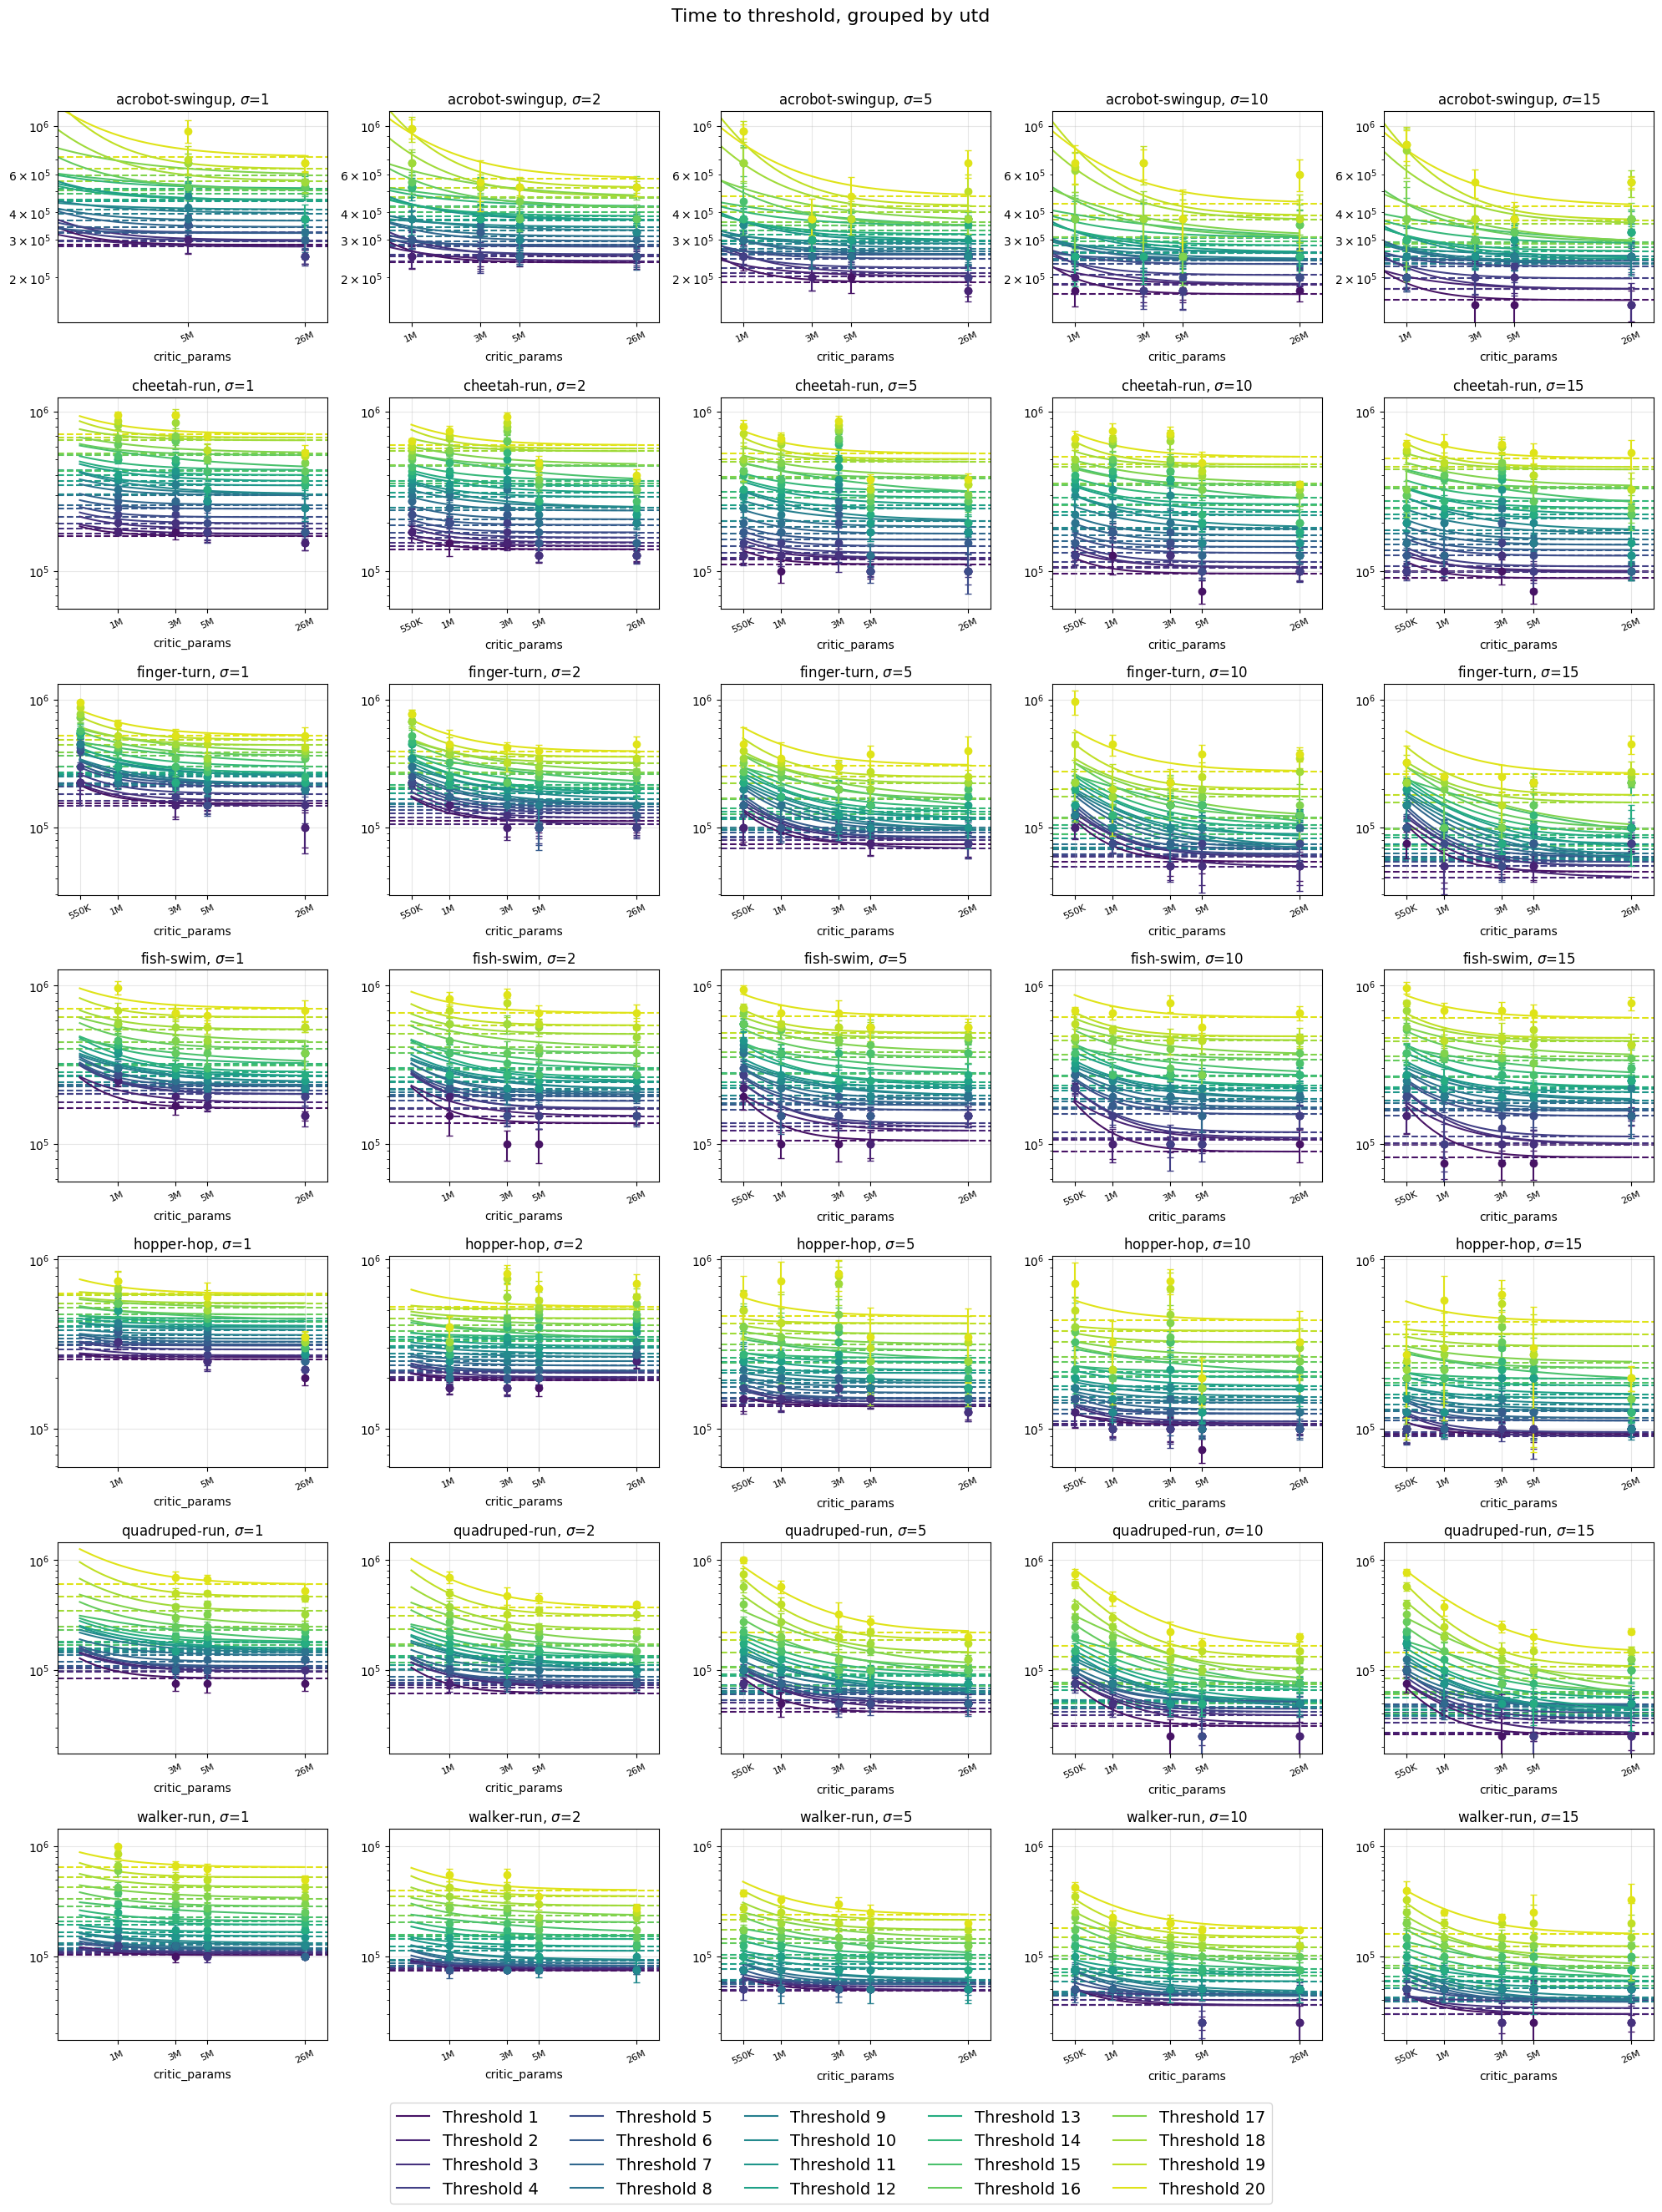

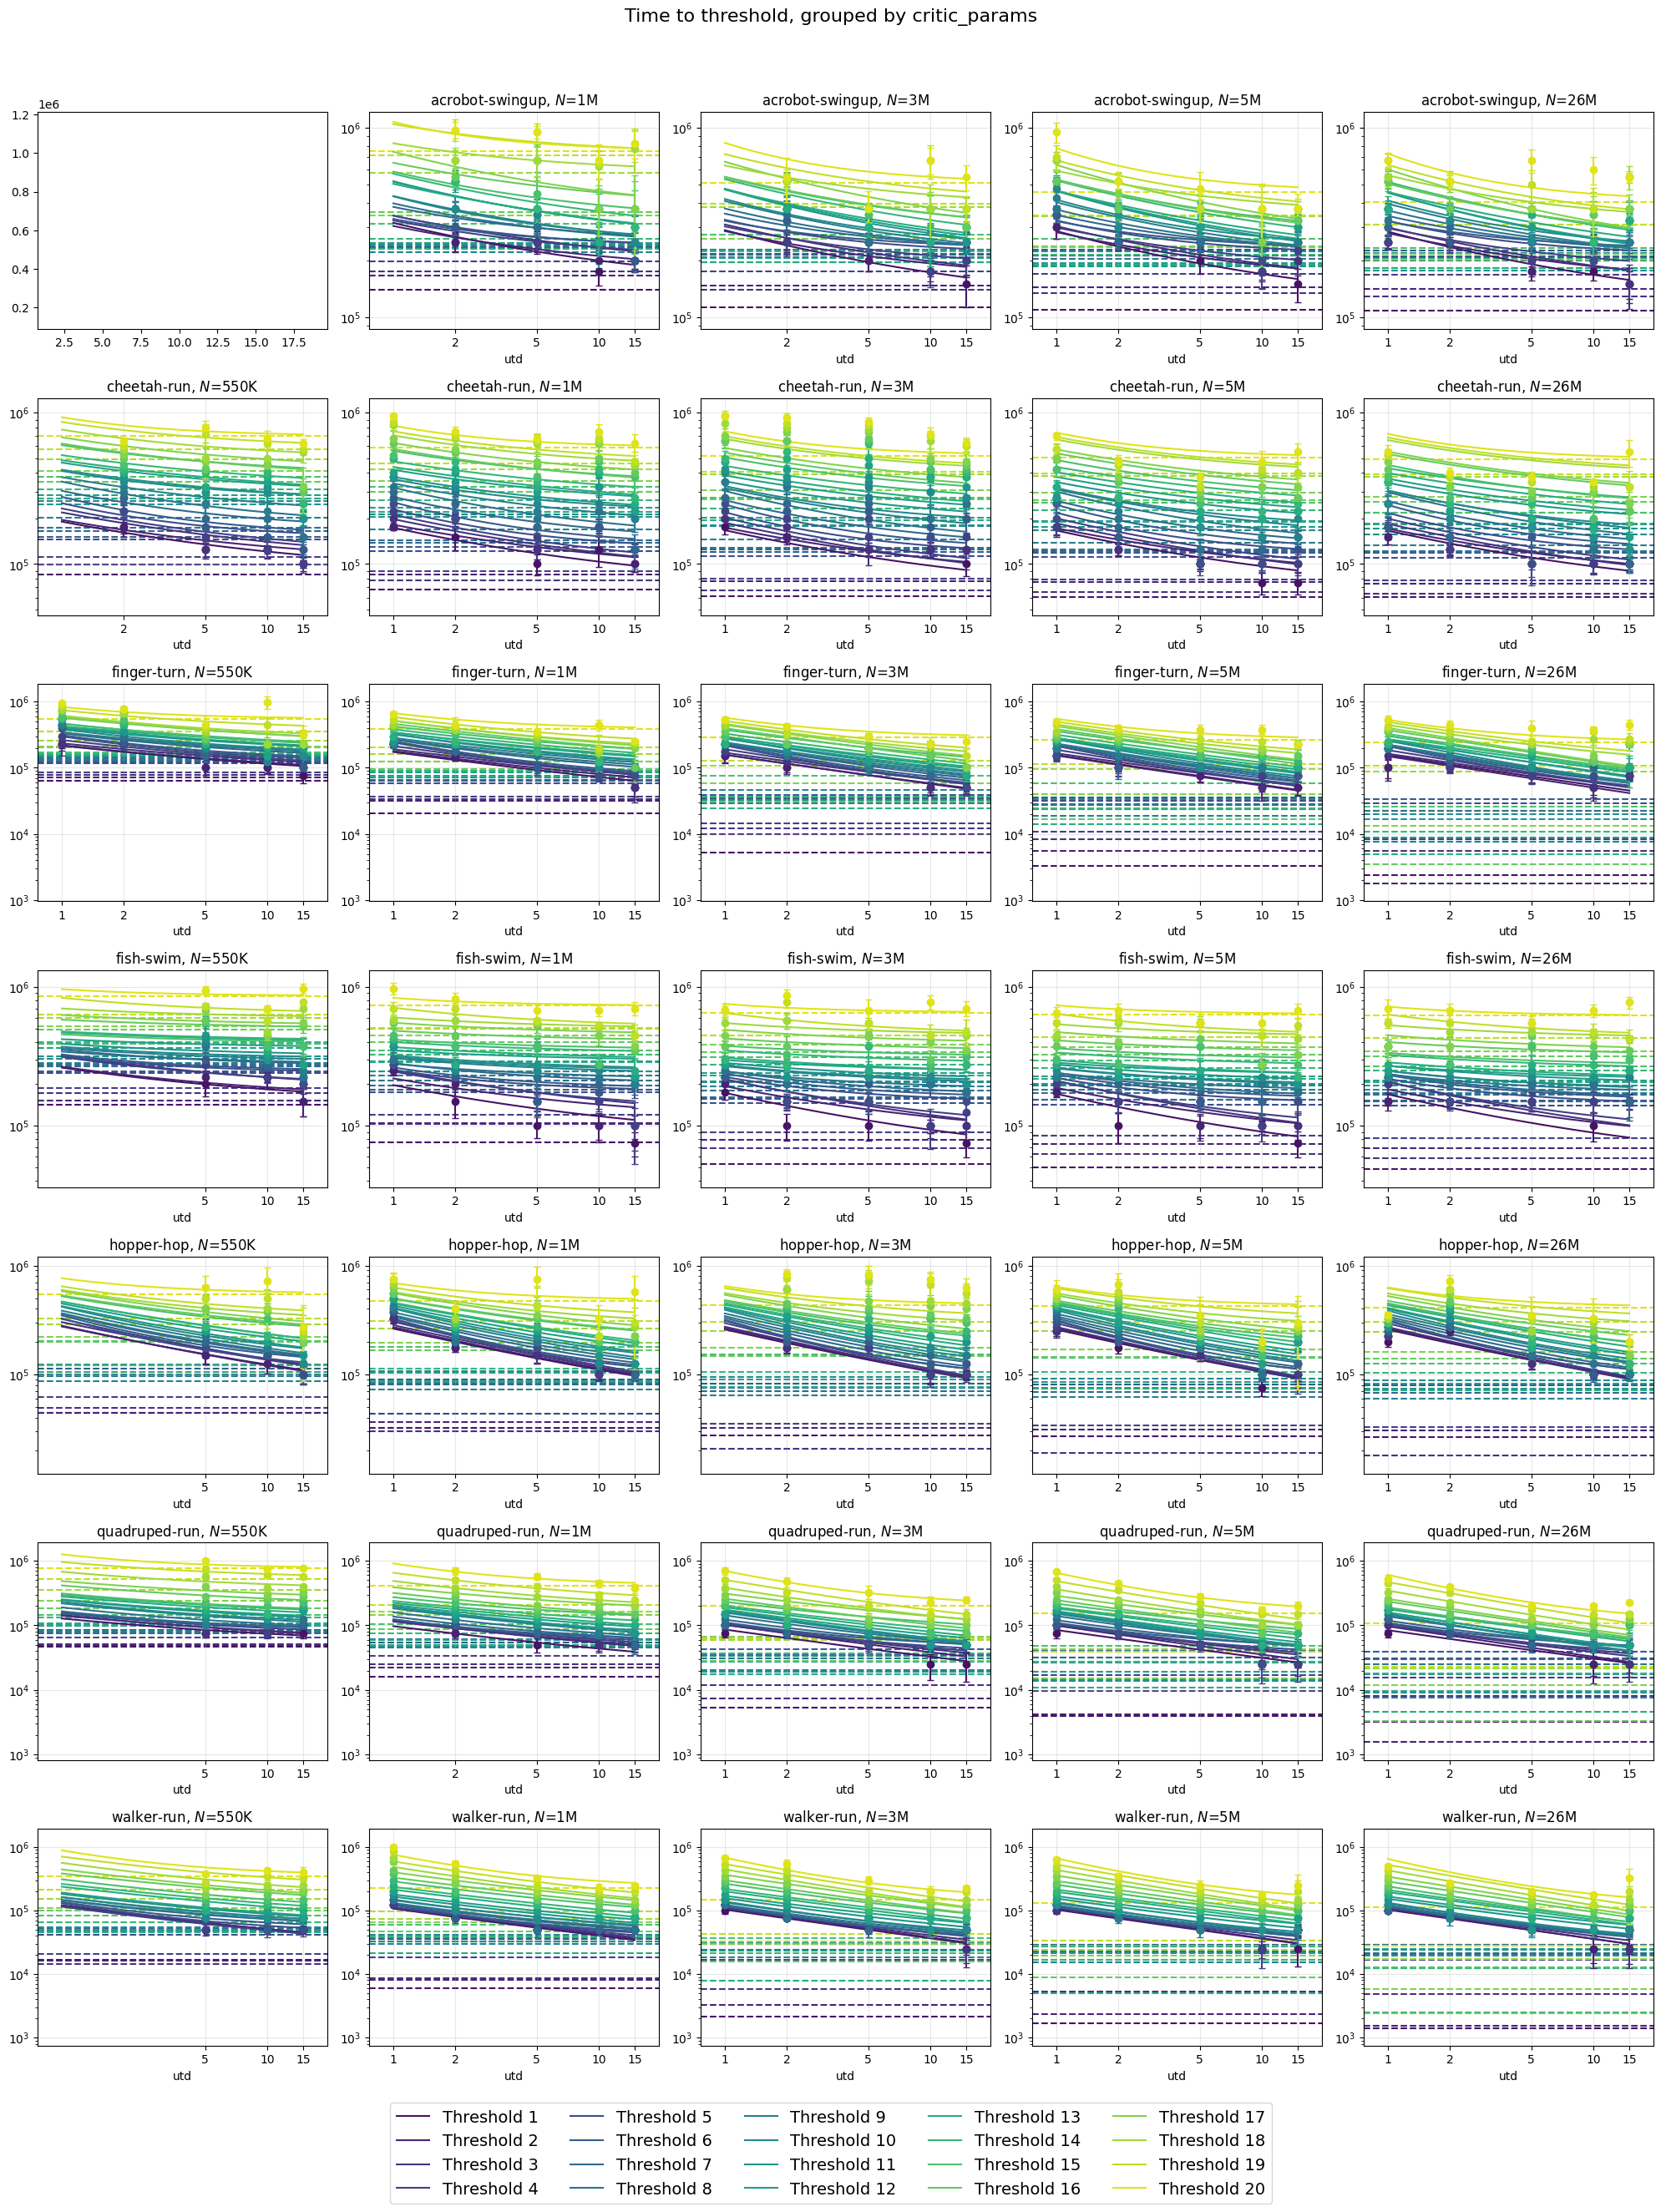

In [ ]:
def plot_multiple_data_efficiency(multiple_crossings_state, fit_type):
    (
        multiple_crossings_df,
        time_to_thresholds_predictors,
        time_to_thresholds_infos_utd,
        time_to_thresholds_infos_n,
    ) = multiple_crossings_state

    dfs_list = []
    for i in range(n_thresholds):
        cols = ['env_name', 'critic_params', 'utd', f'crossing{i}', f'crossing{i}_std']
        dfs_list.append(
            multiple_crossings_df[cols].rename(
                columns={f'crossing{i}': 'time', f'crossing{i}_std': 'time_std'}
            )
        )

    plot_optimal_hparam_fit_per_env_utd_multiple_thresh(
        dfs_list,
        'time',
        'time_std',
        'Time to threshold',
        [
            (time_to_thresholds_predictors[i][fit_type], time_to_thresholds_infos_utd[i][fit_type])
            for i in range(n_thresholds)
        ],
    )

    plot_optimal_hparam_fit_per_env_n_multiple_thresh(
        dfs_list,
        'time',
        'time_std',
        'Time to threshold',
        [
            (time_to_thresholds_predictors[i][fit_type], time_to_thresholds_infos_n[i][fit_type])
            for i in range(n_thresholds)
        ],
        group_col='critic_params',
    )


plot_multiple_data_efficiency(multiple_crossings_state, 'sum_of_powerlaw_shared_exp')

# Averaged

## Fitting

In [79]:
normalized_times_all, mean_normalized_times, median_median = compute_normalized_times(
    env_data_efficiency_dict, query(filtered_df, good_envs), n_thresholds
)
std_normalized_times = np.std(normalized_times_all, axis=0)

In [ ]:
def make_averaged_threshold_dfs(df, mean_normalized_times, median_median):
    utds = sorted(df['utd'].unique())
    model_sizes = sorted(df['model_size'].unique())
    threshold_dfs = []

    for threshold_idx in range(mean_normalized_times.shape[2]):
        datas = []
        for i, utd in enumerate(utds):
            for j, model_size in enumerate(model_sizes):
                time = median_median * mean_normalized_times[i, j, threshold_idx]
                time_std = median_median * std_normalized_times[i, j, threshold_idx]
                datas.append([utd, model_size, time, time_std])
        threshold_df = pd.DataFrame(datas, columns=['utd', 'critic_params', 'time', 'time_std'])
        threshold_df['env_name'] = ''
        threshold_dfs.append(threshold_df)

    return threshold_dfs


def make_averaged_threshold_fits(threshold_dfs, use_cached=True):
    predict_fns = []
    params_sets = []
    asymptotes_per_utd = []
    asymptotes_per_model_size = []

    for threshold_idx, threshold_df in enumerate(threshold_dfs):
        # linear
        (
            threshold_df,
            (
                time_to_thresh_model,
                time_to_thresh_shared_slope,
                time_to_thresh_env_intercepts,
                time_to_thresh_r2,
            ),
        ) = insert_predictions(threshold_df, xcols, 'time')

        predict_data_efficiency_shared_slope_ = (
            lambda slope, intercept: lambda df: predict_log_linear(df, xcols, slope, intercept)
        )(time_to_thresh_shared_slope, time_to_thresh_env_intercepts)

        # sum powerlaw
        threshold_df, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
            threshold_df,
            xcols,
            'time',
            name=f'{anonymous_data_config.name}_averaged_threshold{threshold_idx}',
            use_cached=use_cached,
            log_loss=True,
        )

        predict_data_efficiency_sum_powerlaw_ = (
            lambda params: lambda df: predict_sum_of_powerlaw(df, xcols, params)
        )(time_to_thresh_sum_powerlaw_params)

        data_efficiency_sum_powerlaw_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for utd in df['utd'].unique()
        }

        data_efficiency_sum_powerlaw_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for n in df['critic_params'].unique()
        }

        threshold_dfs[threshold_idx] = threshold_df
        predict_fns.append(
            {
                'linear': predict_data_efficiency_shared_slope_,
                'sum_powerlaw': predict_data_efficiency_sum_powerlaw_,
            }
        )
        params_sets.append({'sum_powerlaw': time_to_thresh_sum_powerlaw_params})
        asymptotes_per_utd.append({'sum_powerlaw': data_efficiency_sum_powerlaw_asymptotes_utd})
        asymptotes_per_model_size.append(
            {'sum_powerlaw': data_efficiency_sum_powerlaw_asymptotes_n}
        )

    return threshold_dfs, predict_fns, params_sets, asymptotes_per_utd, asymptotes_per_model_size


averaged_threshold_dfs = make_averaged_threshold_dfs(
    query(filtered_df, good_envs), mean_normalized_times, median_median
)
(
    averaged_threshold_dfs,
    averaged_predict_fns,
    averaged_params_sets,
    averaged_asymptotes_per_utd,
    averaged_asymptotes_per_model_size,
) = make_averaged_threshold_fits(averaged_threshold_dfs, use_cached=global_use_cached and False)

: log time ~ 1.2920e+01 + -0.3254 * log utd + -0.0464 * log critic_params
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_threshold0/utd_critic_params_time_sum_powerlaw.npy
: log time ~ 1.3154e+01 + -0.3035 * log utd + -0.0590 * log critic_params
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_threshold1/utd_critic_params_time_sum_powerlaw.npy
: log time ~ 1.3192e+01 + -0.3162 * log utd + -0.0570 * log critic_params
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_threshold2/utd_critic_params_time_sum_powerlaw.npy
: log time ~ 1.3057e+01 + -0.2930 * log utd + -0.0464 * log critic_params
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_

In [48]:
averaged_data_efficiency_sum_powerlaw_params_df = pd.DataFrame(
    [
        {
            'threshold': i,
            'a': params_set['sum_powerlaw'][''][0],
            'alpha': params_set['sum_powerlaw'][''][1],
            'b': params_set['sum_powerlaw'][''][2],
            'beta': params_set['sum_powerlaw'][''][3],
            'c': params_set['sum_powerlaw'][''][4],
            'alpha_unscaled': params_set['sum_powerlaw'][''][5],
            'beta_unscaled': params_set['sum_powerlaw'][''][6],
            'a_unscaled': params_set['sum_powerlaw'][''][7],
            'b_unscaled': params_set['sum_powerlaw'][''][8],
            'c_unscaled': params_set['sum_powerlaw'][''][9],
        }
        for i, params_set in enumerate(averaged_params_sets)
    ]
)

averaged_data_efficiency_sum_powerlaw_params_df

threshold           a     alpha             b      beta              c  \
0           0  306.188961  0.399083  1.107170e+06  2.461338   18185.558705   
1           1    8.253207  0.542397  5.405528e+05  1.035547   49524.118886   
2           2    7.147066  0.570281  6.250535e+05  1.484910   54645.663899   
3           3    1.832682  0.851858  4.660858e+05  1.701147   89067.942028   
4           4    1.282978  1.045847  1.792401e+05  0.892683  108237.248274   
5           5    1.365018  0.994644  3.848763e+04  0.390664  105159.456198   
6           6    1.950821  0.774505  1.454781e+05  0.488095   95968.360900   
7           7    1.662736  0.813246  2.362087e+05  0.738556  110660.195312   
8           8    2.222216  0.735086  3.180300e+05  0.633850  103272.998586   
9           9    2.050508  0.818197  2.680194e+05  0.446853  106665.968278   
10         10    2.894134  0.731191  4.482166e+05  0.323210   95837.843625   
11         11    5.098898  0.590102  8.411376e+05  0.376410   87489.519950   
12         12    6.602434  0.560479  9.917727e+05  0.345300   86997.851763   
13         13    2.028923  0.713224  2.815221e+05  0.575475  149070.451778   
14         14    2.188976  0.766475  4.650403e+05  0.550916  153263.983412   
15         15    2.481197  0.657093  5.805106e+05  0.954184  170487.852864   
16         16    3.324830  0.648771  7.194498e+05  0.733271  167469.412562   
17         17    1.854334  0.816940  6.450957e+05  0.687435  226061.303140   
18         18    2.387532  0.810863  8.363374e+05  0.628515  233376.871800   
19         19    1.260591  1.010386  6.331981e+05  0.890187  371869.576617   

    alpha_unscaled  beta_unscaled  a_unscaled  b_unscaled  c_unscaled  
0         0.779586       5.719104    9.366729    0.511540    0.137287  
1         1.059543       2.406171    1.473004    0.375727    0.350072  
2         1.114012       3.450300    1.368396    0.399963    0.365746  
3         1.664058       3.952742    0.681787    0.352507    0.564236  
4         2.043005       2.074217    0.568027    0.233642    0.638907  
5         1.942983       0.907738    0.586340    0.120507    0.592656  
6         1.512953       1.134125    0.703942    0.213571    0.512842  
7         1.588632       1.716090    0.648654    0.263109    0.556685  
8         1.435951       1.472797    0.752481    0.299039    0.488796  
9         1.598303       1.038297    0.722133    0.277811    0.479968  
10        1.428341       0.751002    0.861448    0.346626    0.402005  
11        1.152731       0.874616    1.151167    0.454481    0.344225  
12        1.094866       0.802330    1.313983    0.487873    0.318161  
13        1.393244       1.337159    0.718231    0.283751    0.496973  
14        1.497266       1.280094    0.746698    0.352167    0.464110  
15        1.283595       2.217118    0.796166    0.387437    0.473762  
16        1.267338       1.703810    0.924852    0.424921    0.413587  
17        1.595847       1.597306    0.685898    0.405432    0.485280  
18        1.583977       1.460401    0.780635    0.453363    0.431573  
19        1.973734       2.068416    0.562931    0.402197    0.569402

In [49]:
def wrap(params_df):
    params_df = deepcopy(params_df.iloc[-1:])
    params_df['env_name'] = 'averaged'
    print_data_efficiency_params(params_df)


wrap(averaged_data_efficiency_sum_powerlaw_params_df)

\texttt{averaged} &\qquad \mathrm{3.72e5} \left(1 + \parens{\tfrac{\mathrm{1.26e0}}{\sigma}}^{1.01} + \parens{\tfrac{\mathrm{6.33e5}}{N}}^{0.89} \right) \\


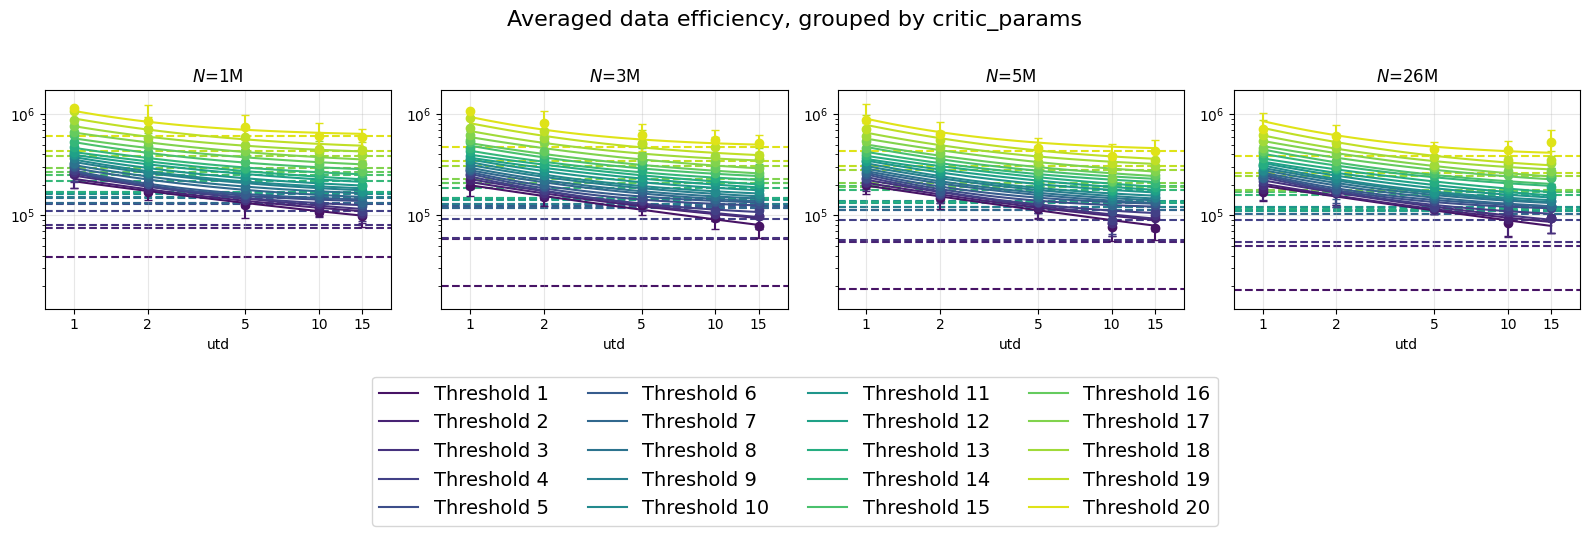

In [50]:
plot_optimal_hparam_fit_per_env_n_multiple_thresh(
    averaged_threshold_dfs,
    'time',
    'time_std',
    'Averaged data efficiency',
    [
        (
            predict_fns_['sum_powerlaw'],
            {
                'asymptote': asymptotes_per_model_size_['sum_powerlaw'],
                # 'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha_{\text{env}}}} + \dfrac{b_{\text{env}}}{N^{\beta_{\text{env}}}}$',
            },
        )
        for predict_fns_, asymptotes_per_model_size_ in zip(
            averaged_predict_fns, averaged_asymptotes_per_model_size
        )
    ],
)

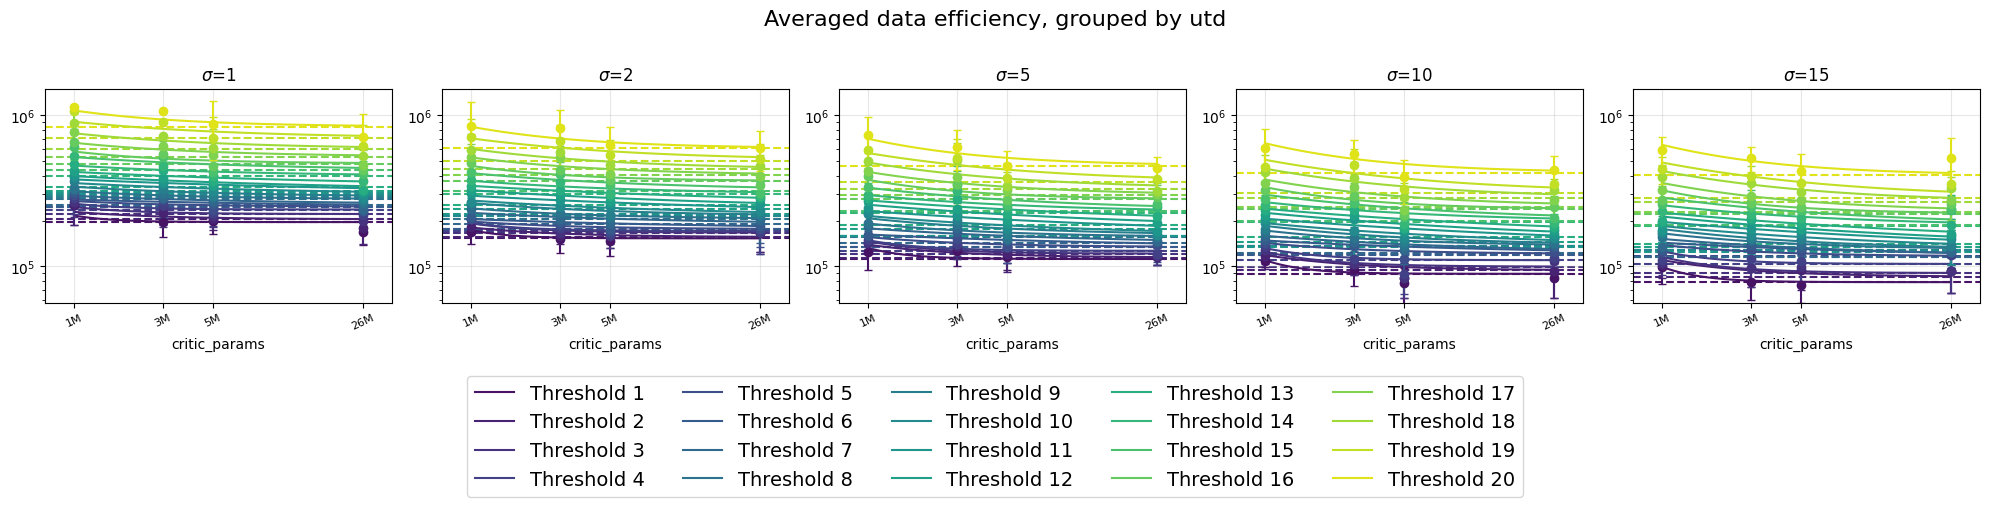

In [53]:
plot_optimal_hparam_fit_per_env_utd_multiple_thresh(
    averaged_threshold_dfs,
    'time',
    'time_std',
    'Averaged data efficiency',
    [
        (
            predict_fns_['sum_powerlaw'],
            {
                'asymptote': asymptotes_per_utd_['sum_powerlaw'],
                # 'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha_{\text{env}}}} + \dfrac{b_{\text{env}}}{N^{\beta_{\text{env}}}}$',
            },
        )
        for predict_fns_, asymptotes_per_utd_ in zip(
            averaged_predict_fns, averaged_asymptotes_per_utd
        )
    ],
)

## Averaged iso plots

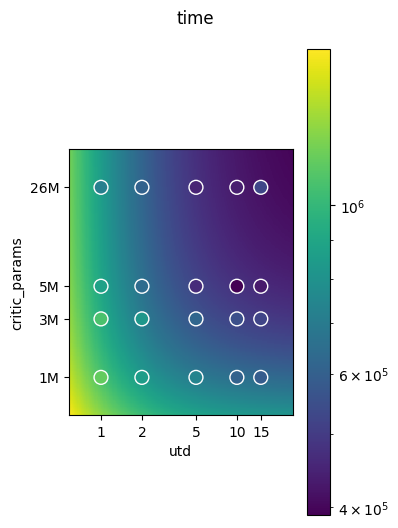

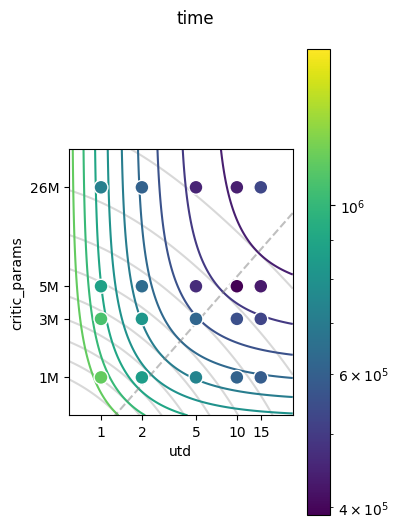

UTD vs N tradeoff for compute conditioned on data
   N = 4.2043e+05 * sigma^1.1390


In [57]:
plot_optimal_hparams_scatter(
    averaged_threshold_dfs[-1],
    averaged_predict_fns[-1]['sum_powerlaw'],
    'time',
    mode='data_predictions',
)

averaged_data_optimal_hparams = plot_optimal_hparams_scatter(
    averaged_threshold_dfs[-1],
    averaged_predict_fns[-1]['sum_powerlaw'],
    'time',
    mode='data_contour',
)

print('UTD vs N tradeoff for compute conditioned on data')
averaged_data_optimal_hparam_relation = compute_optimal_slope_and_intercept(
    averaged_data_optimal_hparams
)
pretty_print_dict(
    {
        row['env_name']: row['eq_sigma_to_n']
        for _, row in averaged_data_optimal_hparam_relation.iterrows()
    }
)

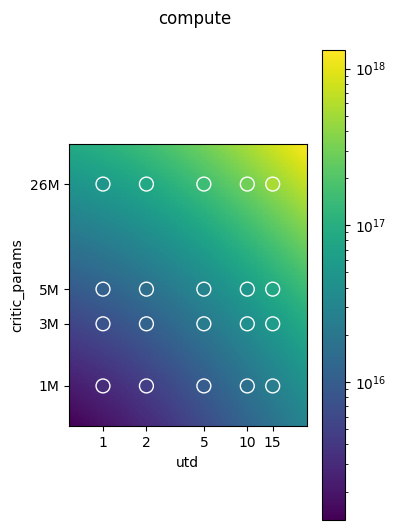

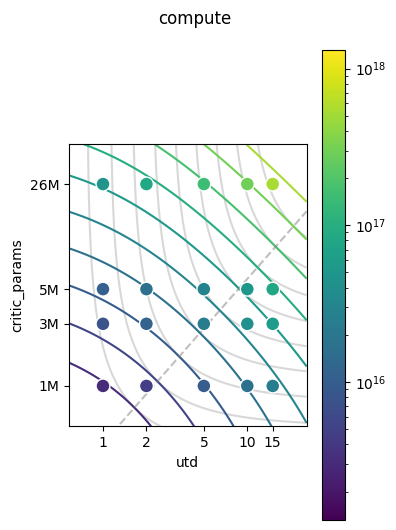

UTD vs N tradeoff for data conditioned on compute
   N = 4.1916e+05 * sigma^1.1404


In [58]:
plot_optimal_hparams_scatter(
    averaged_threshold_dfs[-1],
    averaged_predict_fns[-1]['sum_powerlaw'],
    'time',
    mode='compute_predictions',
)

averaged_compute_optimal_hparams = plot_optimal_hparams_scatter(
    averaged_threshold_dfs[-1],
    averaged_predict_fns[-1]['sum_powerlaw'],
    'time',
    mode='compute_contour',
)

print('UTD vs N tradeoff for data conditioned on compute')
averaged_optimal_hparam_relation = compute_optimal_slope_and_intercept(
    averaged_compute_optimal_hparams
)
pretty_print_dict(
    {
        row['env_name']: row['eq_sigma_to_n']
        for _, row in averaged_optimal_hparam_relation.iterrows()
    }
)

# Budget optimal

In [61]:
delta_dict = defaultdict(lambda: '1e11')

In [ ]:
def compute_multiple_optimal_budget(multiple_crossings_df, infos, delta_dict, use_cached):
    results = []
    for env, group in multiple_crossings_df.groupby('env_name'):
        delta_str = delta_dict[env]

        cache_file = f'budget_optimal/{anonymous_data_config.name}/multiple_budget_optimal_hparams_{env}_{delta_str}_250514.csv'
        if use_cached and os.path.exists(cache_file):
            env_hparams = pd.read_csv(cache_file)
        else:
            env_hparams = compute_optimal_budget(
                group,
                params_per_thresh=[
                    infos[i]['sum_of_powerlaw_shared_exp']['params'] for i in range(n_thresholds)
                ],
                data_efficiency_key_prefix='crossing',
                delta=float(delta_str),
            )
        results.append(env_hparams)
    return pd.concat(results)


multiple_budget_optimal_hparams = compute_multiple_optimal_budget(
    multiple_crossings_df,
    time_to_thresholds_infos_utd,
    delta_dict,
    use_cached=global_use_cached and True,
)

  0%|          | 0/20 [00:00<?, ?it/s]/home/anonymous/model_scaling_project/single/scripts/core/fitting.py:852: RuntimeWarning: divide by zero encountered in log
  return np.exp(s * np.log(x_scaled) + m)
/home/anonymous/model_scaling_project/single/scripts/core/fitting.py:811: RuntimeWarning: divide by zero encountered in scalar divide
  return c * (1 + (a / x1) ** alpha + (b / x2) ** beta)
/home/anonymous/model_scaling_project/single/scripts/experiments/utd_x_width_x_bs/plot_utils.py:149: RuntimeWarning: invalid value encountered in scalar multiply
  compute = 10 * batch_size * utd * critic_params * data
  0%|          | 0/20 [00:00<?, ?it/s]/home/anonymous/model_scaling_project/single/scripts/core/fitting.py:852: RuntimeWarning: divide by zero encountered in log
  return np.exp(s * np.log(x_scaled) + m)
/home/anonymous/model_scaling_project/single/scripts/core/fitting.py:811: RuntimeWarning: divide by zero encountered in scalar divide
  return c * (1 + (a / x1) ** alpha + (b / x2) **

In [63]:
multiple_budget_optimal_hparams_with_fit = insert_budget_fitted_hparams(
    multiple_budget_optimal_hparams.query(
        '(env_name=="humanoid-stand" and threshold_idx>0) or (env_name!="humanoid-stand")'
    ),
    params_per_thresh=[
        time_to_thresholds_infos_utd[i]['sum_powerlaw']['params'] for i in range(n_thresholds)
    ],
)

print(
    'data error:',
    (
        multiple_budget_optimal_hparams_with_fit['budget_fitted_utd_n_data']
        / multiple_budget_optimal_hparams_with_fit['budget_fitted_data_efficiency']
        - 1
    )
    .abs()
    .mean(),
    'compute error:',
    (
        multiple_budget_optimal_hparams_with_fit['budget_fitted_utd_n_compute']
        / multiple_budget_optimal_hparams_with_fit['budget_fitted_compute']
        - 1
    )
    .abs()
    .mean(),
)

multiple_budget_optimal_hparams_with_fit

/home/anonymous/model_scaling_project/single/scripts/core/fitting.py:847: RuntimeWarning: invalid value encountered in divide
  x_scaled = np.exp((np.log(x) - m) / s)
/home/anonymous/model_scaling_project/single/scripts/core/fitting.py:847: RuntimeWarning: invalid value encountered in divide
  x_scaled = np.exp((np.log(x) - m) / s)


data error: 0.12033524200749819 compute error: 0.19265476166257076


env_name         delta  threshold_idx    opt_budget    opt_utd  \
0   acrobot-swingup  1.000000e+11              0  2.458897e+16   6.001191   
1   acrobot-swingup  1.000000e+11              1  2.593705e+16   5.287218   
2   acrobot-swingup  1.000000e+11              2  2.818981e+16   4.807098   
3   acrobot-swingup  1.000000e+11              3  2.830938e+16   4.277252   
4   acrobot-swingup  1.000000e+11              4  3.009032e+16   4.116920   
..              ...           ...            ...           ...        ...   
15       walker-run  1.000000e+11             15  1.688324e+16  14.241369   
16       walker-run  1.000000e+11             16  2.034168e+16  14.076357   
17       walker-run  1.000000e+11             17  2.126617e+16  14.928843   
18       walker-run  1.000000e+11             18  2.579219e+16  14.463534   
19       walker-run  1.000000e+11             19  3.484856e+16   8.527327   

    opt_critic_params  data_efficiency       compute  budget_fitted_utd  \
0        1.380255e+06    202871.054054  4.301865e+15          23.496406   
1        1.125434e+06    225083.410472  3.428709e+15          23.343804   
2        1.548575e+06    236775.722218  4.512242e+15          25.197293   
3        1.322408e+06    247286.547361  3.580724e+15          25.457096   
4        1.164721e+06    268004.629727  3.289855e+15          12.425986   
..                ...              ...           ...                ...   
15       1.412037e+06    111455.321252  5.737711e+15          14.241369   
16       1.272259e+06    139473.282971  6.394354e+15          14.076357   
17       1.464883e+06    136335.008186  7.632670e+15          14.928843   
18       1.525252e+06    164832.698950  9.308919e+15          14.463534   
19       1.790973e+06    250534.462262  9.795112e+15           8.527327   

    budget_fitted_critic_params  budget_fitted_data_efficiency  \
0                  9.225084e+05                   34641.148038   
1                  8.443891e+05                   36398.372972   
2                  6.706206e+05                   36710.759565   
3                  4.540190e+05                   37581.594347   
4                  8.380084e+05                   45049.114482   
..                          ...                            ...   
15                 1.412037e+06                  118032.901956   
16                 1.272259e+06                  141160.852056   
17                 1.464883e+06                  147315.612209   
18                 1.525252e+06                  177302.060429   
19                 1.790973e+06                  236706.782037   

    budget_fitted_compute  budget_fitted_utd_n_data  \
0            1.223177e+15              35175.316536   
1            1.294720e+15              40678.242737   
2            1.307493e+15              41907.246574   
3            1.343186e+15              48766.058824   
4            1.654079e+15              50901.973961   
..                    ...                       ...   
15           5.001528e+15             133037.104601   
16           6.142913e+15             147495.407725   
17           6.451580e+15             167300.043340   
18           7.981807e+15             214601.974065   
19           1.112416e+16             255919.900927   

    budget_fitted_utd_n_compute  
0                  1.922224e+15  
1                  1.836691e+15  
2                  1.588050e+15  
3                  1.111983e+15  
4                  1.200896e+15  
..                          ...  
15                 6.076324e+15  
16                 6.471723e+15  
17                 8.247416e+15  
18                 1.001313e+16  
19                 9.254493e+15  

[140 rows x 14 columns]

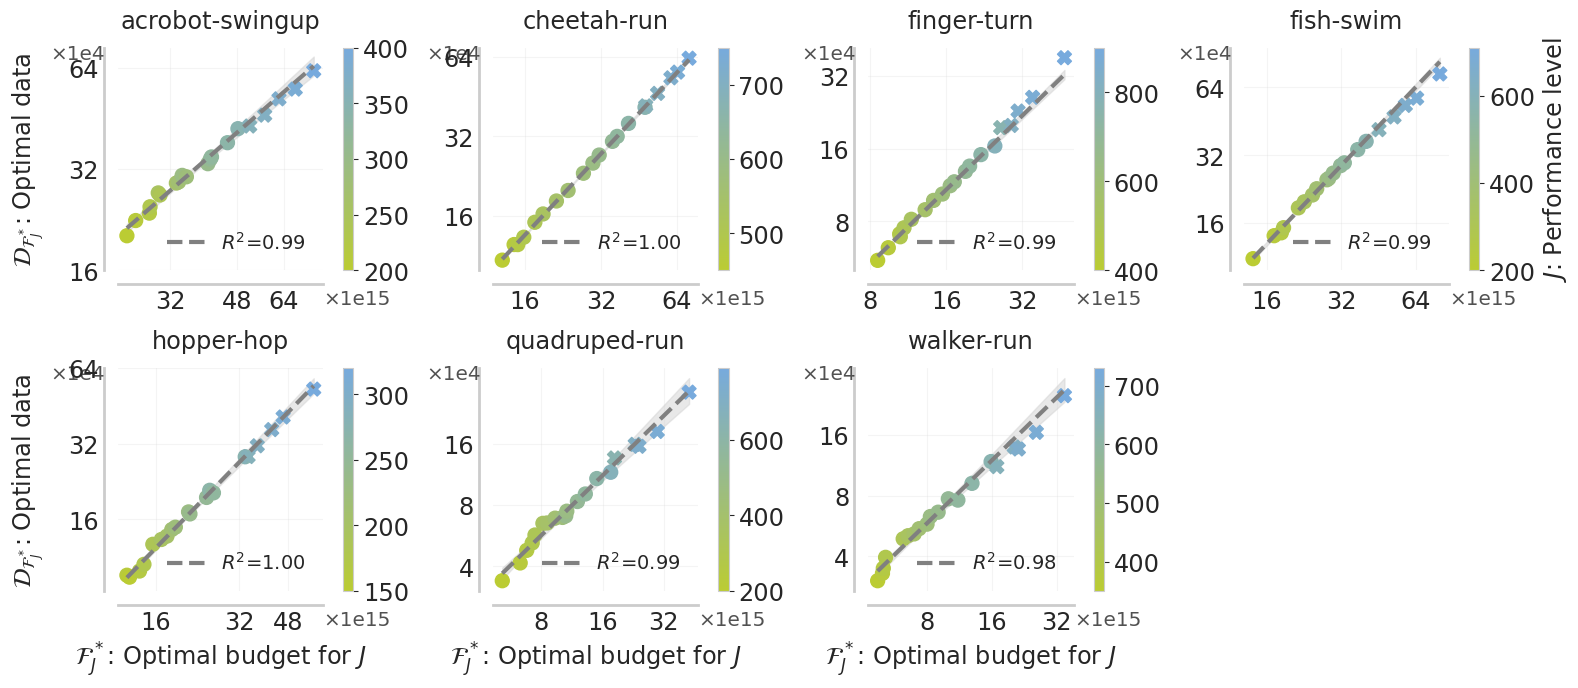

In [65]:
plot_budget_data_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'acrobot-swingup': [32e15, 48e15, 64e15],
        'cheetah-run': [16e15, 32e15, 64e15],
        'finger-turn': [8e15, 16e15, 32e15],
        'fish-swim': [16e15, 32e15, 64e15],
        'hopper-hop': [16e15, 32e15, 48e15],
        'quadruped-run': [8e15, 16e15, 32e15],
        'walker-run': [8e15, 16e15, 32e15],
    },
    xscale='1e15',
    data_yticks={
        'acrobot-swingup': [16e4, 32e4, 64e4],
        'cheetah-run': [16e4, 32e4, 64e4],
        'finger-turn': [8e4, 16e4, 32e4],
        'fish-swim': [16e4, 32e4, 64e4],
        'hopper-hop': [16e4, 32e4, 64e4],
        'quadruped-run': [4e4, 8e4, 16e4],
        'walker-run': [4e4, 8e4, 16e4],
    },
    data_yscale='1e4',
    num_extrapolated_points=5,
    save_path=f'../final_plots/{BENCHMARK_NAME}_budget_data_opt.pdf',
)

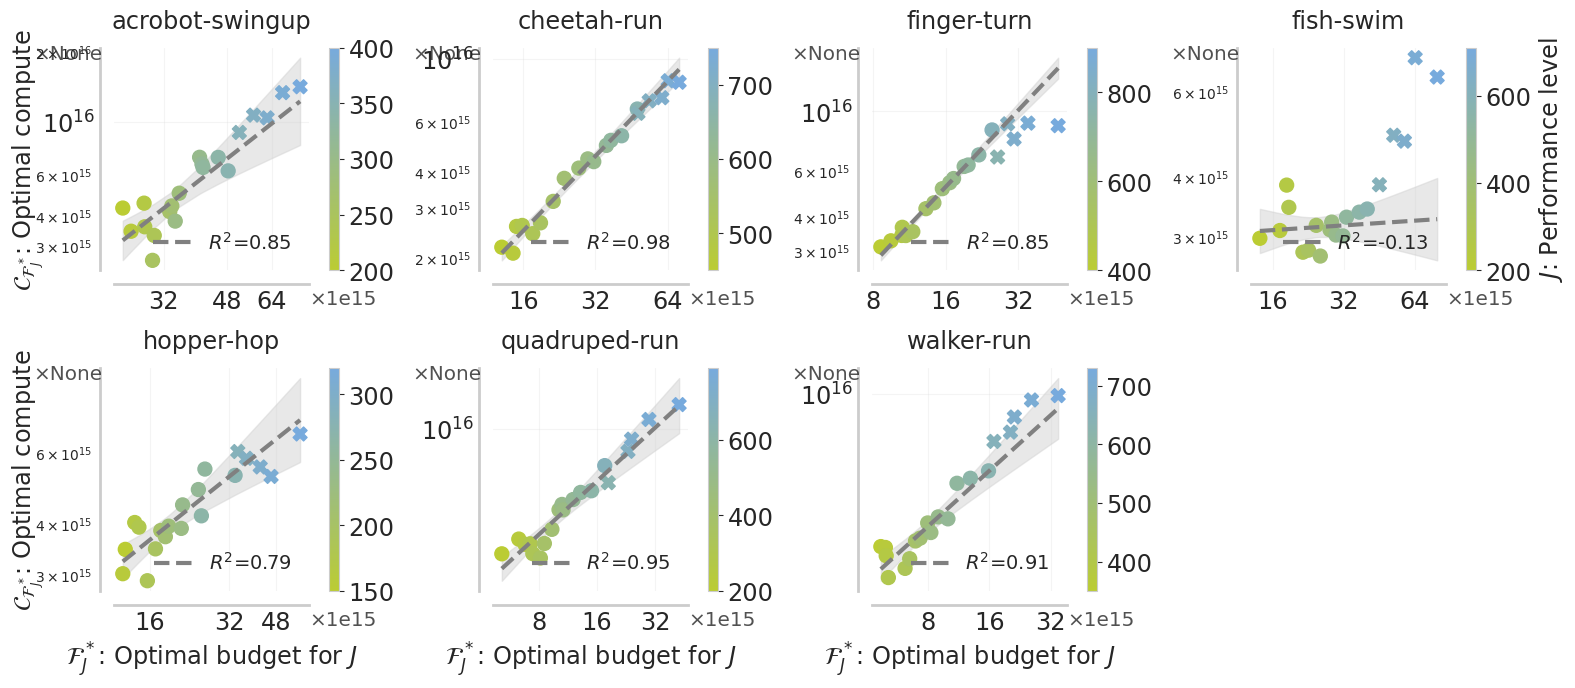

In [ ]:
plot_budget_compute_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'acrobot-swingup': [32e15, 48e15, 64e15],
        'cheetah-run': [16e15, 32e15, 64e15],
        'finger-turn': [8e15, 16e15, 32e15],
        'fish-swim': [16e15, 32e15, 64e15],
        'hopper-hop': [16e15, 32e15, 48e15],
        'quadruped-run': [8e15, 16e15, 32e15],
        'walker-run': [8e15, 16e15, 32e15],
    },
    xscale='1e15',
    num_extrapolated_points=5,
    save_path=f'../final_plots/{BENCHMARK_NAME}_budget_compute_opt.pdf',
)

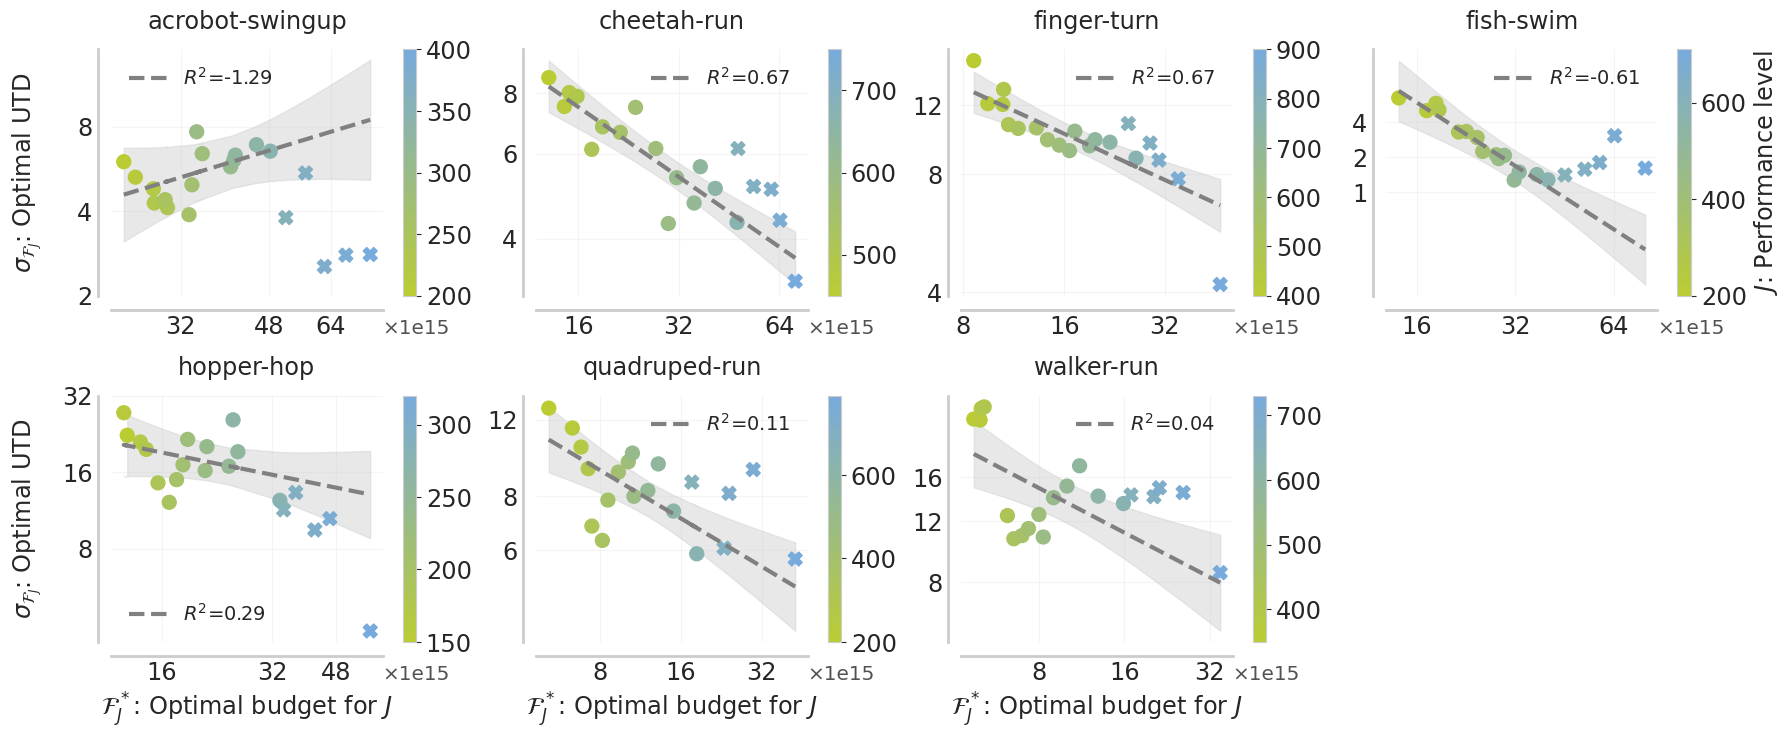

In [67]:
plot_budget_sigma_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'acrobot-swingup': [32e15, 48e15, 64e15],
        'cheetah-run': [16e15, 32e15, 64e15],
        'finger-turn': [8e15, 16e15, 32e15],
        'fish-swim': [16e15, 32e15, 64e15],
        'hopper-hop': [16e15, 32e15, 48e15],
        'quadruped-run': [8e15, 16e15, 32e15],
        'walker-run': [8e15, 16e15, 32e15],
    },
    xscale='1e15',
    sigma_yticks={
        'acrobot-swingup': [2, 4, 8],
        'cheetah-run': [4, 6, 8],
        'finger-turn': [4, 8, 12],
        'fish-swim': [1, 2, 4],
        'hopper-hop': [8, 16, 32],
        'quadruped-run': [6, 8, 12],
        'walker-run': [8, 12, 16],
    },
    sigma_yscale='1',
    num_extrapolated_points=5,
    save_path=f'../final_plots/{BENCHMARK_NAME}_budget_sigma_opt.pdf',
)

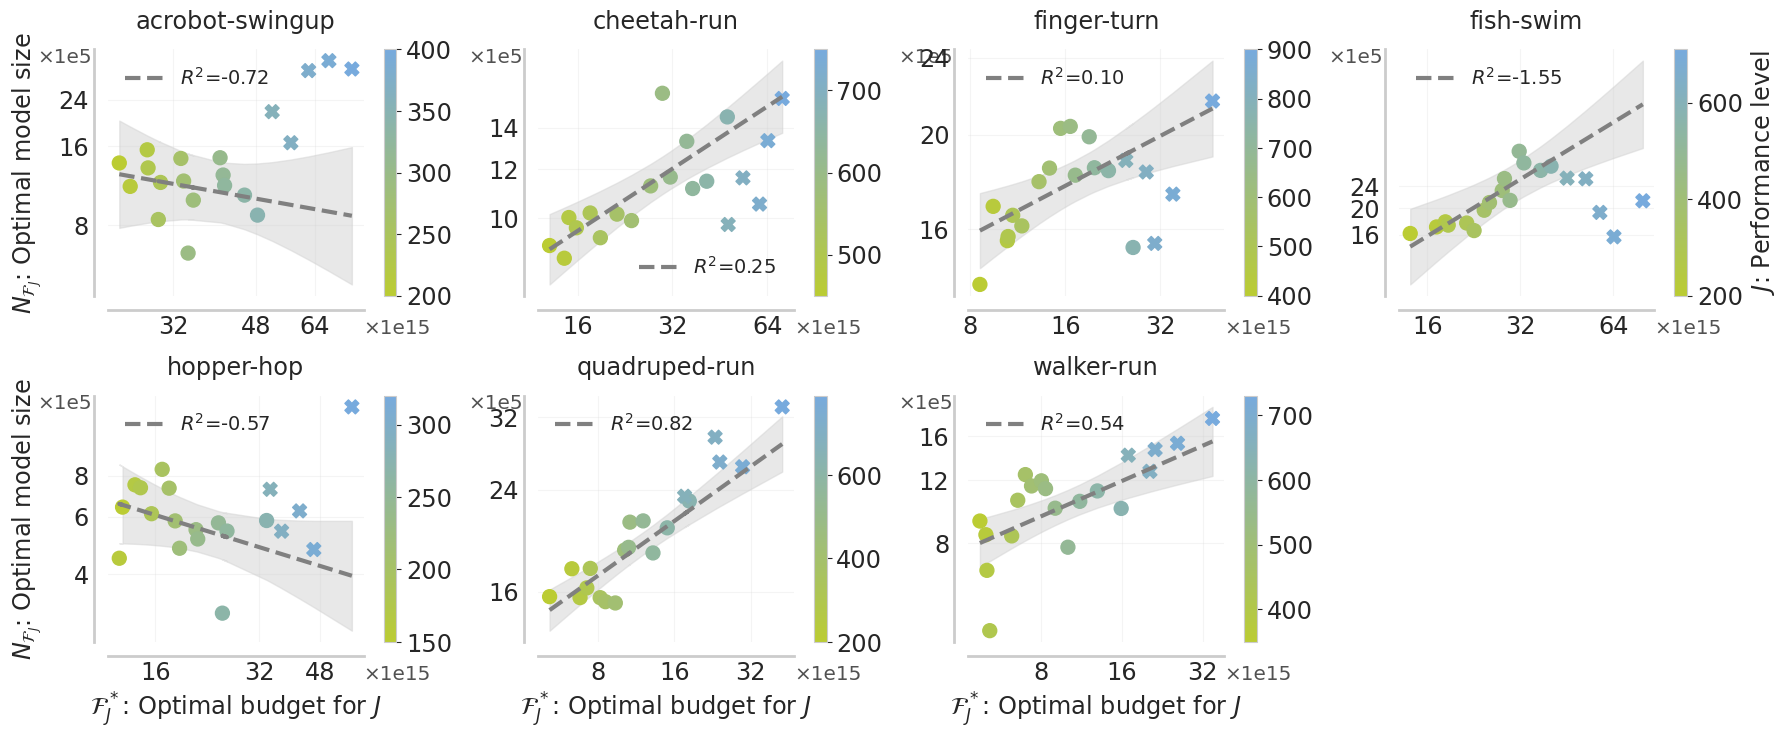

In [68]:
plot_budget_n_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'acrobot-swingup': [32e15, 48e15, 64e15],
        'cheetah-run': [16e15, 32e15, 64e15],
        'finger-turn': [8e15, 16e15, 32e15],
        'fish-swim': [16e15, 32e15, 64e15],
        'hopper-hop': [16e15, 32e15, 48e15],
        'quadruped-run': [8e15, 16e15, 32e15],
        'walker-run': [8e15, 16e15, 32e15],
    },
    xscale='1e15',
    n_yticks={
        'acrobot-swingup': [8e5, 16e5, 24e5],
        'cheetah-run': [10e5, 12e5, 14e5],
        'finger-turn': [16e5, 20e5, 24e5],
        'fish-swim': [16e5, 20e5, 24e5],
        'hopper-hop': [4e5, 6e5, 8e5],
        'quadruped-run': [16e5, 24e5, 32e5],
        'walker-run': [8e5, 12e5, 16e5],
    },
    n_yscale='1e5',
    num_extrapolated_points=5,
    save_path=f'../final_plots/{BENCHMARK_NAME}_budget_n_opt.pdf',
)

## Averaged budget optimal

In [69]:
def make_averaged_multiple_crossings_df(averaged_threshold_dfs):
    df = averaged_threshold_dfs[0][['env_name', 'utd', 'critic_params']]
    for i in range(n_thresholds):
        df[f'crossing{i}'] = averaged_threshold_dfs[i][f'time']
        df[f'crossing{i}_std'] = averaged_threshold_dfs[i][f'time_std']
    return df


averaged_multiple_crossings_df = make_averaged_multiple_crossings_df(averaged_threshold_dfs)

In [ ]:
averaged_config = deepcopy(anonymous_data_config)
averaged_config.name += '_averaged'

In [ ]:
averaged_generic_fit_infos = {
    'loglinear_shared': {
        'color': 'tab:orange',
        'label': r'$D \sim a_{\text{env},\sigma} \cdot N^{\beta}$',
    },
    'sum_powerlaw': {
        'color': 'tab:purple',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha_{\text{env}}}} + \dfrac{b_{\text{env}}}{N^{\beta_{\text{env}}}}$',
    },
    'sum_of_powerlaw_shared_exp': {
        'color': 'darkturquoise',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha}} + \dfrac{b_{\text{env}}}{N^{\beta}}$',
    },
}

averaged_time_to_thresholds_predictors = [{} for _ in range(n_thresholds)]
averaged_time_to_thresholds_infos_utd = [
    deepcopy(averaged_generic_fit_infos) for _ in range(n_thresholds)
]
averaged_time_to_thresholds_infos_n = [
    deepcopy(averaged_generic_fit_infos) for _ in range(n_thresholds)
]

averaged_multiple_crossings_state = (
    averaged_multiple_crossings_df,
    averaged_time_to_thresholds_predictors,
    averaged_time_to_thresholds_infos_utd,
    averaged_time_to_thresholds_infos_n,
)

In [72]:
averaged_multiple_crossings_state = insert_multiple_shared_slope(
    averaged_multiple_crossings_state, fn=insert_predictions
)

: log crossing0 ~ 1.2920e+01 + -0.3254 * log utd + -0.0464 * log critic_params
: log crossing1 ~ 1.3154e+01 + -0.3035 * log utd + -0.0590 * log critic_params
: log crossing2 ~ 1.3192e+01 + -0.3162 * log utd + -0.0570 * log critic_params
: log crossing3 ~ 1.3057e+01 + -0.2930 * log utd + -0.0464 * log critic_params
: log crossing4 ~ 1.3053e+01 + -0.2615 * log utd + -0.0440 * log critic_params
: log crossing5 ~ 1.3109e+01 + -0.2547 * log utd + -0.0450 * log critic_params
: log crossing6 ~ 1.3343e+01 + -0.2628 * log utd + -0.0562 * log critic_params
: log crossing7 ~ 1.3400e+01 + -0.2584 * log utd + -0.0563 * log critic_params
: log crossing8 ~ 1.3661e+01 + -0.2664 * log utd + -0.0688 * log critic_params
: log crossing9 ~ 1.3752e+01 + -0.2670 * log utd + -0.0715 * log critic_params
: log crossing10 ~ 1.3801e+01 + -0.2641 * log utd + -0.0702 * log critic_params
: log crossing11 ~ 1.3952e+01 + -0.2563 * log utd + -0.0765 * log critic_params
: log crossing12 ~ 1.4038e+01 + -0.2581 * log utd 

In [73]:
averaged_multiple_crossings_state = insert_multiple_sum_powerlaw(
    averaged_multiple_crossings_state, averaged_config, use_cached=False
)

  0%|          | 0/20 [00:00<?, ?it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing0/utd_critic_params_crossing0_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing1/utd_critic_params_crossing1_sum_powerlaw.npy


 25%|██▌       | 5/20 [00:00<00:00, 21.94it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing2/utd_critic_params_crossing2_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing3/utd_critic_params_crossing3_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing4/utd_critic_params_crossing4_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing5/utd_critic_params_crossing5_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing6/utd_critic_params_crossing6_sum_powerlaw.npy


 55%|█████▌    | 11/20 [00:00<00:00, 25.25it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing7/utd_critic_params_crossing7_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing8/utd_critic_params_crossing8_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing9/utd_critic_params_crossing9_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing10/utd_critic_params_crossing10_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing11/utd_critic_params_crossing11_sum_powerlaw.npy
Saved params to /home

 90%|█████████ | 18/20 [00:00<00:00, 27.91it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing13/utd_critic_params_crossing13_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing14/utd_critic_params_crossing14_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing15/utd_critic_params_crossing15_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing16/utd_critic_params_crossing16_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing17/utd_critic_params_crossing17_sum_powerlaw.npy
Saved params to

100%|██████████| 20/20 [00:00<00:00, 25.99it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing19/utd_critic_params_crossing19_sum_powerlaw.npy


In [74]:
averaged_multiple_crossings_state = insert_multiple_sum_powerlaw_shared_exp(
    averaged_multiple_crossings_state, averaged_config, use_cached=False
)

 10%|█         | 2/20 [00:00<00:00, 18.41it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing0/utd_critic_params_crossing0_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing1/utd_critic_params_crossing1_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing2/utd_critic_params_crossing2_sum_of_powerlaw_shared_exp_no_log_loss.npy


 25%|██▌       | 5/20 [00:00<00:00, 21.72it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing3/utd_critic_params_crossing3_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing4/utd_critic_params_crossing4_sum_of_powerlaw_shared_exp_no_log_loss.npy


 40%|████      | 8/20 [00:00<00:00, 23.08it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing5/utd_critic_params_crossing5_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing6/utd_critic_params_crossing6_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing7/utd_critic_params_crossing7_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing8/utd_critic_params_crossing8_sum_of_powerlaw_shared_exp_no_log_loss.npy


 55%|█████▌    | 11/20 [00:00<00:00, 24.57it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing9/utd_critic_params_crossing9_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing10/utd_critic_params_crossing10_sum_of_powerlaw_shared_exp_no_log_loss.npy


 70%|███████   | 14/20 [00:00<00:00, 24.26it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing11/utd_critic_params_crossing11_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing12/utd_critic_params_crossing12_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing13/utd_critic_params_crossing13_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing14/utd_critic_params_crossing14_sum_of_powerlaw_shared_exp_no_log_loss.npy


 85%|████████▌ | 17/20 [00:00<00:00, 25.53it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing15/utd_critic_params_crossing15_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing16/utd_critic_params_crossing16_sum_of_powerlaw_shared_exp_no_log_loss.npy


/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[idx, f'{ycol}_sum_of_powerlaw_shared_exp'] = predict_sum_of_powerlaw_shared_exponent(
/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[idx, f'{ycol}_sum_of_powerlaw_shared_exp'] = predict_sum_of_powerlaw_shared_exponent(
100%|██████████| 20/20 [00:00<00:00, 25.18it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing17/utd_critic_params_crossing17_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing18/utd_critic_params_crossing18_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dmc_linear20_with_base_averaged_crossing19/utd_critic_params_crossing19_sum_of_powerlaw_shared_exp_no_log_loss.npy


In [76]:
(
    averaged_multiple_crossings_df,
    averaged_time_to_thresholds_predictors,
    averaged_time_to_thresholds_infos_utd,
    averaged_time_to_thresholds_infos_n,
) = averaged_multiple_crossings_state

In [77]:
averaged_multiple_budget_optimal_hparams = compute_multiple_optimal_budget(
    averaged_multiple_crossings_df,
    averaged_time_to_thresholds_infos_utd,
    delta_dict={'': '1e11'},
    use_cached=False,
)
averaged_multiple_budget_optimal_hparams['env_name'] = ''

100%|██████████| 20/20 [00:00<00:00, 482.62it/s]


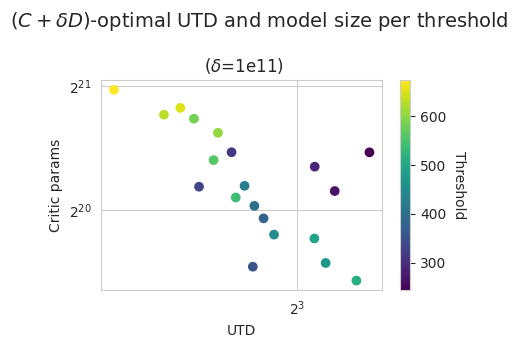

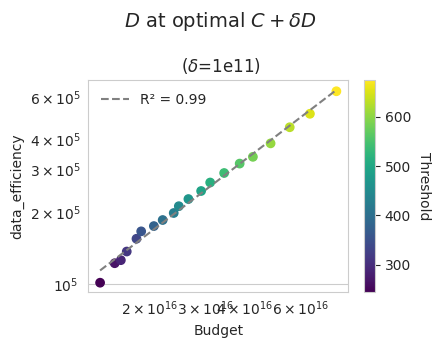

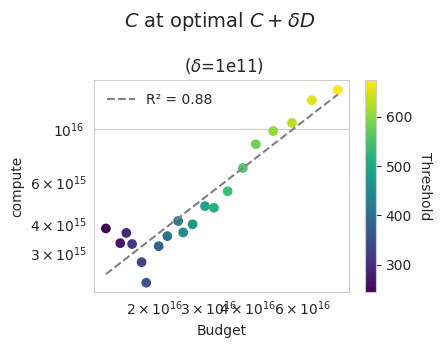

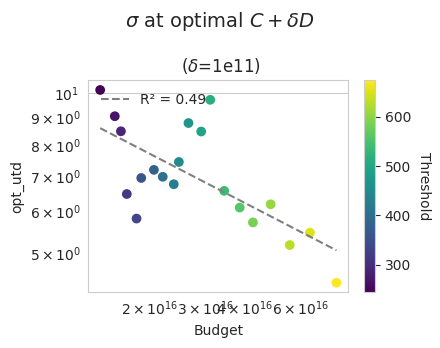

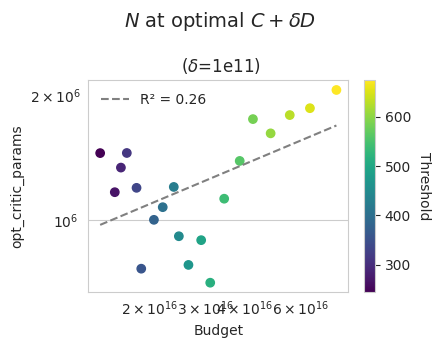

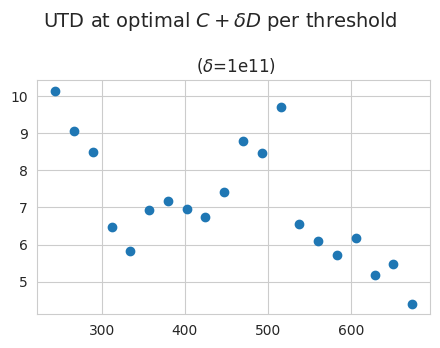

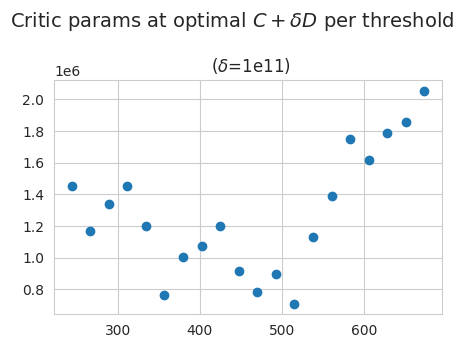

In [78]:
averaged_optimal_d_budget_fit, averaged_optimal_c_budget_fit = compute_budget_data_compute_equation(
    averaged_multiple_budget_optimal_hparams
)
plot_multiple_budget_optimal(
    averaged_multiple_budget_optimal_hparams,
    delta_dict={'': '1e11'},
    thresholds_per_env=pd.Series({'': np.stack(thresholds_per_env.values).mean(axis=0)}),
)